# AORC Precipitation
#!pip install --upgrade ras-commander

#Import the ras-commander package
from ras_commander import *

##### Optional Code Cell For Development/Testing Mode (Local Copy)
##### Uncomment and run this cell instead of the pip cell above

# For Development Mode, add the parent directory to the Python path
import os
import sys
from pathlib import Path

current_file = Path(os.getcwd()).resolve()
rascmdr_directory = current_file.parent

# Use insert(0) instead of append() to give highest priority to local version
if str(rascmdr_directory) not in sys.path:
    sys.path.insert(0, str(rascmdr_directory))

print("Loading ras-commander from local dev copy")
from ras_commander import *

# AORC Gridded Precipitation for HEC-RAS

This notebook demonstrates a complete workflow for using NOAA's Analysis of Record for Calibration (AORC) gridded precipitation data with HEC-RAS rain-on-grid models.

**Example Project**: BaldEagleCrkMulti2D

## Workflow
1. Generate a storm catalog from historical AORC data
2. Visualize precipitation for each storm event
3. Create HEC-RAS plans for all storms
4. Execute all plans in parallel
5. Extract and compare results at a monitoring point

## AORC Dataset Overview
- **Coverage**: CONUS (1979-present), Alaska (1981-present)
- **Resolution**: ~800 meters, hourly timesteps
- **Format**: Cloud-optimized Zarr on AWS S3
- **Access**: Anonymous (no authentication required)

In [1]:
# Install precipitation dependencies
# Uncomment if needed:
# !pip install xarray zarr s3fs netCDF4 rioxarray

In [2]:
# Standard imports
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

# For development/testing: Use local dev copy (has precip module)
# Add parent directory to path FIRST to prioritize local version
current_file = Path.cwd()
parent_directory = current_file.parent
if str(parent_directory) not in sys.path:
    sys.path.insert(0, str(parent_directory))

from ras_commander import init_ras_project, RasExamples, RasPlan, RasUnsteady, RasCmdr
from ras_commander.precip import PrecipAorc
from ras_commander import HdfMesh, HdfResultsMesh

print(f"Using ras_commander from: {Path(init_ras_project.__module__.replace('.', '/')).parent}")

Using ras_commander from: ras_commander


## Step 1: Setup Project and Parameters

In [3]:
# Extract BaldEagleCrkMulti2D example project
project_path = RasExamples.extract_project("BaldEagleCrkMulti2D")
print(f"Project extracted to: {project_path}")

# Initialize project
ras = init_ras_project(project_path, "6.6")
print(f"\nProject: {ras.project_name}")
print(f"Plans: {len(ras.plan_df)}")

2025-12-05 19:05:13 - ras_commander.RasExamples - INFO - Found zip file: c:\GH\ras-commander\examples\Example_Projects_6_6.zip


2025-12-05 19:05:13 - ras_commander.RasExamples - INFO - Loading project data from CSV...


2025-12-05 19:05:13 - ras_commander.RasExamples - INFO - Loaded 68 projects from CSV.


2025-12-05 19:05:13 - ras_commander.RasExamples - INFO - ----- RasExamples Extracting Project -----


2025-12-05 19:05:13 - ras_commander.RasExamples - INFO - Extracting project 'BaldEagleCrkMulti2D'


2025-12-05 19:05:13 - ras_commander.RasExamples - INFO - Project 'BaldEagleCrkMulti2D' already exists. Deleting existing folder...


2025-12-05 19:05:13 - ras_commander.RasExamples - INFO - Existing folder for project 'BaldEagleCrkMulti2D' has been deleted.


2025-12-05 19:05:15 - ras_commander.RasExamples - INFO - Successfully extracted project 'BaldEagleCrkMulti2D' to c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D


2025-12-05 19:05:15 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.rasmap


Project extracted to: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D

Project: BaldEagleDamBrk
Plans: 11


In [4]:
# Define project parameters
bounds = (-77.71, 41.01, -77.25, 41.22)  # WGS84 bounding box
year = 2020  # Year to analyze
template_plan = "06"  # Template with precipitation enabled
monitoring_point = (2078811, 367670)  # Results extraction point (project CRS)

print(f"Project Bounds (WGS84): W={bounds[0]}, S={bounds[1]}, E={bounds[2]}, N={bounds[3]}")
print(f"Analysis Year: {year}")
print(f"Template Plan: {template_plan}")
print(f"Monitoring Point: {monitoring_point}")

Project Bounds (WGS84): W=-77.71, S=41.01, E=-77.25, N=41.22
Analysis Year: 2020
Template Plan: 06
Monitoring Point: (2078811, 367670)


## Step 2: Generate Storm Catalog

Analyze AORC data to identify all significant precipitation events for the year.

In [5]:
# Generate storm catalog
storm_catalog = PrecipAorc.get_storm_catalog(
    bounds=bounds,
    year=year,
    inter_event_hours=8.0,      # USGS standard for storm separation
    min_depth_inches=0.75,      # Minimum significant precipitation
    buffer_hours=48             # Simulation warmup buffer
)

print(f"\nStorm Catalog: {len(storm_catalog)} events")
print("="*80)
print(storm_catalog[['storm_id', 'start_time', 'end_time', 'total_depth_in', 
                     'peak_intensity_in_hr', 'duration_hours', 'rank']].to_string(index=False))

2025-12-05 19:05:15 - ras_commander.precip.PrecipAorc - INFO - Generating storm catalog for 2020


2025-12-05 19:05:15 - ras_commander.precip.PrecipAorc - INFO -   Bounds: W=-77.7100, S=41.0100, E=-77.2500, N=41.2200


2025-12-05 19:05:15 - ras_commander.precip.PrecipAorc - INFO -   Parameters: inter_event=8.0h, min_depth=0.75in, buffer=48h


2025-12-05 19:05:15 - ras_commander.precip.PrecipAorc - INFO - Connecting to AWS S3...


2025-12-05 19:05:15 - ras_commander.precip.PrecipAorc - INFO - Loading s3://noaa-nws-aorc-v1-1-1km/2020.zarr...


2025-12-05 19:05:16 - ras_commander.precip.PrecipAorc - INFO - Loading spatial subset...


2025-12-05 19:05:16 - ras_commander.precip.PrecipAorc - INFO - Loaded 8784 hourly timesteps


2025-12-05 19:05:16 - ras_commander.precip.PrecipAorc - INFO - Identified 142 raw events


2025-12-05 19:05:16 - ras_commander.precip.PrecipAorc - INFO - Storm catalog complete: 13 storms


2025-12-05 19:05:16 - ras_commander.precip.PrecipAorc - INFO -   Total depth range: 0.76 - 2.70 inches


2025-12-05 19:05:16 - ras_commander.precip.PrecipAorc - INFO -   Largest storm: 2020-12-24 12:00:00 (2.70 in)



Storm Catalog: 13 events
 storm_id          start_time            end_time  total_depth_in  peak_intensity_in_hr  duration_hours  rank
        1 2020-02-07 09:00:00 2020-02-07 17:00:00           0.991                 0.271               9     9
        2 2020-03-19 01:00:00 2020-03-19 10:00:00           0.757                 0.206              10    13
        3 2020-03-28 08:00:00 2020-03-29 11:00:00           1.498                 0.166              28     6
        4 2020-04-26 09:00:00 2020-04-27 01:00:00           0.770                 0.096              17    12
        5 2020-04-30 04:00:00 2020-05-01 00:00:00           2.120                 0.196              21     2
        6 2020-05-28 12:00:00 2020-05-29 02:00:00           1.054                 0.378              15     8
        7 2020-06-03 06:00:00 2020-06-03 21:00:00           0.838                 0.333              16    10
        8 2020-06-10 17:00:00 2020-06-11 08:00:00           0.772                 0.205       

## Step 3: Download AORC Data and Visualize Storm Events

Download AORC data and plot precipitation hyetographs for each storm in the catalog.

In [6]:
# Create precipitation folder
precip_folder = project_path / "Precipitation"
precip_folder.mkdir(exist_ok=True)

# Download AORC data for all storms
print("Downloading AORC data for all storms...")
print("="*60)

precip_files = {}
for idx, storm in storm_catalog.iterrows():
    storm_id = storm['storm_id']
    date_str = storm['start_time'].strftime('%Y%m%d')
    precip_file = precip_folder / f"storm_{date_str}.nc"
    
    if not precip_file.exists():
        print(f"  Storm {storm_id}: {storm['start_time'].strftime('%b %d')} - Downloading...")
        PrecipAorc.download(
            bounds=bounds,
            start_time=storm['sim_start'],
            end_time=storm['sim_end'],
            output_path=precip_file,
            target_crs="EPSG:5070",
            resolution=2000.0
        )
    else:
        print(f"  Storm {storm_id}: {storm['start_time'].strftime('%b %d')} - Already downloaded")
    
    precip_files[storm_id] = precip_file

print(f"\nDownloaded {len(precip_files)} precipitation files")

2025-12-05 19:05:17 - ras_commander.precip.PrecipAorc - INFO - Downloading AORC data:


2025-12-05 19:05:17 - ras_commander.precip.PrecipAorc - INFO -   Bounds: W=-77.7100, S=41.0100, E=-77.2500, N=41.2200


2025-12-05 19:05:17 - ras_commander.precip.PrecipAorc - INFO -   Time range: 2020-02-05 09:00:00 to 2020-02-09 17:00:00


2025-12-05 19:05:17 - ras_commander.precip.PrecipAorc - INFO -   Variable: APCP_surface


2025-12-05 19:05:17 - ras_commander.precip.PrecipAorc - INFO - Connecting to AWS S3...


2025-12-05 19:05:17 - ras_commander.precip.PrecipAorc - INFO -   Loading year 2020 from s3://noaa-nws-aorc-v1-1-1km/2020.zarr


  Storm 1: Feb 07 - Downloading...


2025-12-05 19:05:17 - ras_commander.precip.PrecipAorc - INFO -     Loaded Frozen({'time': 120, 'latitude': 25, 'longitude': 55})


2025-12-05 19:05:17 - ras_commander.precip.PrecipAorc - INFO - Combining datasets...


2025-12-05 19:05:17 - ras_commander.precip.PrecipAorc - INFO - Reprojecting to EPSG:5070 at 2000.0m resolution...


2025-12-05 19:05:17 - ras_commander.precip.PrecipAorc - INFO - Reprojected grid shape: (120, 16, 22)


2025-12-05 19:05:17 - ras_commander.precip.PrecipAorc - INFO - Writing to NetCDF: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\Precipitation\storm_20200207.nc


2025-12-05 19:05:17 - ras_commander.precip.PrecipAorc - INFO - Download complete: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\Precipitation\storm_20200207.nc (0.1 MB)


2025-12-05 19:05:17 - ras_commander.precip.PrecipAorc - INFO - Downloading AORC data:


2025-12-05 19:05:17 - ras_commander.precip.PrecipAorc - INFO -   Bounds: W=-77.7100, S=41.0100, E=-77.2500, N=41.2200


2025-12-05 19:05:17 - ras_commander.precip.PrecipAorc - INFO -   Time range: 2020-03-17 01:00:00 to 2020-03-21 10:00:00


2025-12-05 19:05:17 - ras_commander.precip.PrecipAorc - INFO -   Variable: APCP_surface


2025-12-05 19:05:17 - ras_commander.precip.PrecipAorc - INFO - Connecting to AWS S3...


2025-12-05 19:05:17 - ras_commander.precip.PrecipAorc - INFO -   Loading year 2020 from s3://noaa-nws-aorc-v1-1-1km/2020.zarr


  Storm 2: Mar 19 - Downloading...


2025-12-05 19:05:17 - ras_commander.precip.PrecipAorc - INFO -     Loaded Frozen({'time': 120, 'latitude': 25, 'longitude': 55})


2025-12-05 19:05:17 - ras_commander.precip.PrecipAorc - INFO - Combining datasets...


2025-12-05 19:05:17 - ras_commander.precip.PrecipAorc - INFO - Reprojecting to EPSG:5070 at 2000.0m resolution...


2025-12-05 19:05:17 - ras_commander.precip.PrecipAorc - INFO - Reprojected grid shape: (120, 16, 22)


2025-12-05 19:05:17 - ras_commander.precip.PrecipAorc - INFO - Writing to NetCDF: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\Precipitation\storm_20200319.nc


2025-12-05 19:05:17 - ras_commander.precip.PrecipAorc - INFO - Download complete: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\Precipitation\storm_20200319.nc (0.1 MB)


2025-12-05 19:05:17 - ras_commander.precip.PrecipAorc - INFO - Downloading AORC data:


2025-12-05 19:05:17 - ras_commander.precip.PrecipAorc - INFO -   Bounds: W=-77.7100, S=41.0100, E=-77.2500, N=41.2200


2025-12-05 19:05:17 - ras_commander.precip.PrecipAorc - INFO -   Time range: 2020-03-26 08:00:00 to 2020-03-31 11:00:00


2025-12-05 19:05:17 - ras_commander.precip.PrecipAorc - INFO -   Variable: APCP_surface


2025-12-05 19:05:17 - ras_commander.precip.PrecipAorc - INFO - Connecting to AWS S3...


2025-12-05 19:05:17 - ras_commander.precip.PrecipAorc - INFO -   Loading year 2020 from s3://noaa-nws-aorc-v1-1-1km/2020.zarr


  Storm 3: Mar 28 - Downloading...


2025-12-05 19:05:18 - ras_commander.precip.PrecipAorc - INFO -     Loaded Frozen({'time': 144, 'latitude': 25, 'longitude': 55})


2025-12-05 19:05:18 - ras_commander.precip.PrecipAorc - INFO - Combining datasets...


2025-12-05 19:05:18 - ras_commander.precip.PrecipAorc - INFO - Reprojecting to EPSG:5070 at 2000.0m resolution...


2025-12-05 19:05:18 - ras_commander.precip.PrecipAorc - INFO - Reprojected grid shape: (144, 16, 22)


2025-12-05 19:05:18 - ras_commander.precip.PrecipAorc - INFO - Writing to NetCDF: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\Precipitation\storm_20200328.nc


2025-12-05 19:05:18 - ras_commander.precip.PrecipAorc - INFO - Download complete: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\Precipitation\storm_20200328.nc (0.1 MB)


2025-12-05 19:05:18 - ras_commander.precip.PrecipAorc - INFO - Downloading AORC data:


2025-12-05 19:05:18 - ras_commander.precip.PrecipAorc - INFO -   Bounds: W=-77.7100, S=41.0100, E=-77.2500, N=41.2200


2025-12-05 19:05:18 - ras_commander.precip.PrecipAorc - INFO -   Time range: 2020-04-24 09:00:00 to 2020-04-29 01:00:00


2025-12-05 19:05:18 - ras_commander.precip.PrecipAorc - INFO -   Variable: APCP_surface


2025-12-05 19:05:18 - ras_commander.precip.PrecipAorc - INFO - Connecting to AWS S3...


2025-12-05 19:05:18 - ras_commander.precip.PrecipAorc - INFO -   Loading year 2020 from s3://noaa-nws-aorc-v1-1-1km/2020.zarr


  Storm 4: Apr 26 - Downloading...


2025-12-05 19:05:18 - ras_commander.precip.PrecipAorc - INFO -     Loaded Frozen({'time': 144, 'latitude': 25, 'longitude': 55})


2025-12-05 19:05:18 - ras_commander.precip.PrecipAorc - INFO - Combining datasets...


2025-12-05 19:05:18 - ras_commander.precip.PrecipAorc - INFO - Reprojecting to EPSG:5070 at 2000.0m resolution...


2025-12-05 19:05:18 - ras_commander.precip.PrecipAorc - INFO - Reprojected grid shape: (144, 16, 22)


2025-12-05 19:05:18 - ras_commander.precip.PrecipAorc - INFO - Writing to NetCDF: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\Precipitation\storm_20200426.nc


2025-12-05 19:05:18 - ras_commander.precip.PrecipAorc - INFO - Download complete: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\Precipitation\storm_20200426.nc (0.1 MB)


2025-12-05 19:05:18 - ras_commander.precip.PrecipAorc - INFO - Downloading AORC data:


2025-12-05 19:05:18 - ras_commander.precip.PrecipAorc - INFO -   Bounds: W=-77.7100, S=41.0100, E=-77.2500, N=41.2200


2025-12-05 19:05:18 - ras_commander.precip.PrecipAorc - INFO -   Time range: 2020-04-28 04:00:00 to 2020-05-03 00:00:00


2025-12-05 19:05:18 - ras_commander.precip.PrecipAorc - INFO -   Variable: APCP_surface


2025-12-05 19:05:18 - ras_commander.precip.PrecipAorc - INFO - Connecting to AWS S3...


2025-12-05 19:05:18 - ras_commander.precip.PrecipAorc - INFO -   Loading year 2020 from s3://noaa-nws-aorc-v1-1-1km/2020.zarr


  Storm 5: Apr 30 - Downloading...


2025-12-05 19:05:18 - ras_commander.precip.PrecipAorc - INFO -     Loaded Frozen({'time': 144, 'latitude': 25, 'longitude': 55})


2025-12-05 19:05:18 - ras_commander.precip.PrecipAorc - INFO - Combining datasets...


2025-12-05 19:05:18 - ras_commander.precip.PrecipAorc - INFO - Reprojecting to EPSG:5070 at 2000.0m resolution...


2025-12-05 19:05:18 - ras_commander.precip.PrecipAorc - INFO - Reprojected grid shape: (144, 16, 22)


2025-12-05 19:05:18 - ras_commander.precip.PrecipAorc - INFO - Writing to NetCDF: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\Precipitation\storm_20200430.nc


2025-12-05 19:05:18 - ras_commander.precip.PrecipAorc - INFO - Download complete: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\Precipitation\storm_20200430.nc (0.1 MB)


2025-12-05 19:05:18 - ras_commander.precip.PrecipAorc - INFO - Downloading AORC data:


2025-12-05 19:05:18 - ras_commander.precip.PrecipAorc - INFO -   Bounds: W=-77.7100, S=41.0100, E=-77.2500, N=41.2200


2025-12-05 19:05:18 - ras_commander.precip.PrecipAorc - INFO -   Time range: 2020-05-26 12:00:00 to 2020-05-31 02:00:00


2025-12-05 19:05:18 - ras_commander.precip.PrecipAorc - INFO -   Variable: APCP_surface


2025-12-05 19:05:18 - ras_commander.precip.PrecipAorc - INFO - Connecting to AWS S3...


2025-12-05 19:05:18 - ras_commander.precip.PrecipAorc - INFO -   Loading year 2020 from s3://noaa-nws-aorc-v1-1-1km/2020.zarr


  Storm 6: May 28 - Downloading...


2025-12-05 19:05:18 - ras_commander.precip.PrecipAorc - INFO -     Loaded Frozen({'time': 144, 'latitude': 25, 'longitude': 55})


2025-12-05 19:05:18 - ras_commander.precip.PrecipAorc - INFO - Combining datasets...


2025-12-05 19:05:18 - ras_commander.precip.PrecipAorc - INFO - Reprojecting to EPSG:5070 at 2000.0m resolution...


2025-12-05 19:05:18 - ras_commander.precip.PrecipAorc - INFO - Reprojected grid shape: (144, 16, 22)


2025-12-05 19:05:18 - ras_commander.precip.PrecipAorc - INFO - Writing to NetCDF: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\Precipitation\storm_20200528.nc


2025-12-05 19:05:18 - ras_commander.precip.PrecipAorc - INFO - Download complete: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\Precipitation\storm_20200528.nc (0.1 MB)


2025-12-05 19:05:18 - ras_commander.precip.PrecipAorc - INFO - Downloading AORC data:


2025-12-05 19:05:18 - ras_commander.precip.PrecipAorc - INFO -   Bounds: W=-77.7100, S=41.0100, E=-77.2500, N=41.2200


2025-12-05 19:05:18 - ras_commander.precip.PrecipAorc - INFO -   Time range: 2020-06-01 06:00:00 to 2020-06-05 21:00:00


2025-12-05 19:05:18 - ras_commander.precip.PrecipAorc - INFO -   Variable: APCP_surface


2025-12-05 19:05:18 - ras_commander.precip.PrecipAorc - INFO - Connecting to AWS S3...


2025-12-05 19:05:18 - ras_commander.precip.PrecipAorc - INFO -   Loading year 2020 from s3://noaa-nws-aorc-v1-1-1km/2020.zarr


  Storm 7: Jun 03 - Downloading...


2025-12-05 19:05:19 - ras_commander.precip.PrecipAorc - INFO -     Loaded Frozen({'time': 120, 'latitude': 25, 'longitude': 55})


2025-12-05 19:05:19 - ras_commander.precip.PrecipAorc - INFO - Combining datasets...


2025-12-05 19:05:19 - ras_commander.precip.PrecipAorc - INFO - Reprojecting to EPSG:5070 at 2000.0m resolution...


2025-12-05 19:05:19 - ras_commander.precip.PrecipAorc - INFO - Reprojected grid shape: (120, 16, 22)


2025-12-05 19:05:19 - ras_commander.precip.PrecipAorc - INFO - Writing to NetCDF: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\Precipitation\storm_20200603.nc


2025-12-05 19:05:19 - ras_commander.precip.PrecipAorc - INFO - Download complete: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\Precipitation\storm_20200603.nc (0.1 MB)


2025-12-05 19:05:19 - ras_commander.precip.PrecipAorc - INFO - Downloading AORC data:


2025-12-05 19:05:19 - ras_commander.precip.PrecipAorc - INFO -   Bounds: W=-77.7100, S=41.0100, E=-77.2500, N=41.2200


2025-12-05 19:05:19 - ras_commander.precip.PrecipAorc - INFO -   Time range: 2020-06-08 17:00:00 to 2020-06-13 08:00:00


2025-12-05 19:05:19 - ras_commander.precip.PrecipAorc - INFO -   Variable: APCP_surface


2025-12-05 19:05:19 - ras_commander.precip.PrecipAorc - INFO - Connecting to AWS S3...


2025-12-05 19:05:19 - ras_commander.precip.PrecipAorc - INFO -   Loading year 2020 from s3://noaa-nws-aorc-v1-1-1km/2020.zarr


  Storm 8: Jun 10 - Downloading...


2025-12-05 19:05:19 - ras_commander.precip.PrecipAorc - INFO -     Loaded Frozen({'time': 144, 'latitude': 25, 'longitude': 55})


2025-12-05 19:05:19 - ras_commander.precip.PrecipAorc - INFO - Combining datasets...


2025-12-05 19:05:19 - ras_commander.precip.PrecipAorc - INFO - Reprojecting to EPSG:5070 at 2000.0m resolution...


2025-12-05 19:05:19 - ras_commander.precip.PrecipAorc - INFO - Reprojected grid shape: (144, 16, 22)


2025-12-05 19:05:19 - ras_commander.precip.PrecipAorc - INFO - Writing to NetCDF: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\Precipitation\storm_20200610.nc


2025-12-05 19:05:19 - ras_commander.precip.PrecipAorc - INFO - Download complete: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\Precipitation\storm_20200610.nc (0.1 MB)


2025-12-05 19:05:19 - ras_commander.precip.PrecipAorc - INFO - Downloading AORC data:


2025-12-05 19:05:19 - ras_commander.precip.PrecipAorc - INFO -   Bounds: W=-77.7100, S=41.0100, E=-77.2500, N=41.2200


2025-12-05 19:05:19 - ras_commander.precip.PrecipAorc - INFO -   Time range: 2020-09-27 11:00:00 to 2020-10-02 08:00:00


2025-12-05 19:05:19 - ras_commander.precip.PrecipAorc - INFO -   Variable: APCP_surface


2025-12-05 19:05:19 - ras_commander.precip.PrecipAorc - INFO - Connecting to AWS S3...


2025-12-05 19:05:19 - ras_commander.precip.PrecipAorc - INFO -   Loading year 2020 from s3://noaa-nws-aorc-v1-1-1km/2020.zarr


  Storm 9: Sep 29 - Downloading...


2025-12-05 19:05:19 - ras_commander.precip.PrecipAorc - INFO -     Loaded Frozen({'time': 144, 'latitude': 25, 'longitude': 55})


2025-12-05 19:05:19 - ras_commander.precip.PrecipAorc - INFO - Combining datasets...


2025-12-05 19:05:19 - ras_commander.precip.PrecipAorc - INFO - Reprojecting to EPSG:5070 at 2000.0m resolution...


2025-12-05 19:05:19 - ras_commander.precip.PrecipAorc - INFO - Reprojected grid shape: (144, 16, 22)


2025-12-05 19:05:19 - ras_commander.precip.PrecipAorc - INFO - Writing to NetCDF: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\Precipitation\storm_20200929.nc


2025-12-05 19:05:19 - ras_commander.precip.PrecipAorc - INFO - Download complete: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\Precipitation\storm_20200929.nc (0.1 MB)


2025-12-05 19:05:19 - ras_commander.precip.PrecipAorc - INFO - Downloading AORC data:


2025-12-05 19:05:19 - ras_commander.precip.PrecipAorc - INFO -   Bounds: W=-77.7100, S=41.0100, E=-77.2500, N=41.2200


2025-12-05 19:05:19 - ras_commander.precip.PrecipAorc - INFO -   Time range: 2020-10-27 08:00:00 to 2020-11-01 18:00:00


2025-12-05 19:05:19 - ras_commander.precip.PrecipAorc - INFO -   Variable: APCP_surface


2025-12-05 19:05:19 - ras_commander.precip.PrecipAorc - INFO - Connecting to AWS S3...


2025-12-05 19:05:19 - ras_commander.precip.PrecipAorc - INFO -   Loading year 2020 from s3://noaa-nws-aorc-v1-1-1km/2020.zarr


  Storm 10: Oct 29 - Downloading...


2025-12-05 19:05:20 - ras_commander.precip.PrecipAorc - INFO -     Loaded Frozen({'time': 144, 'latitude': 25, 'longitude': 55})


2025-12-05 19:05:20 - ras_commander.precip.PrecipAorc - INFO - Combining datasets...


2025-12-05 19:05:20 - ras_commander.precip.PrecipAorc - INFO - Reprojecting to EPSG:5070 at 2000.0m resolution...


2025-12-05 19:05:20 - ras_commander.precip.PrecipAorc - INFO - Reprojected grid shape: (144, 16, 22)


2025-12-05 19:05:20 - ras_commander.precip.PrecipAorc - INFO - Writing to NetCDF: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\Precipitation\storm_20201029.nc


2025-12-05 19:05:20 - ras_commander.precip.PrecipAorc - INFO - Download complete: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\Precipitation\storm_20201029.nc (0.1 MB)


2025-12-05 19:05:20 - ras_commander.precip.PrecipAorc - INFO - Downloading AORC data:


2025-12-05 19:05:20 - ras_commander.precip.PrecipAorc - INFO -   Bounds: W=-77.7100, S=41.0100, E=-77.2500, N=41.2200


2025-12-05 19:05:20 - ras_commander.precip.PrecipAorc - INFO -   Time range: 2020-11-09 13:00:00 to 2020-11-13 22:00:00


2025-12-05 19:05:20 - ras_commander.precip.PrecipAorc - INFO -   Variable: APCP_surface


2025-12-05 19:05:20 - ras_commander.precip.PrecipAorc - INFO - Connecting to AWS S3...


2025-12-05 19:05:20 - ras_commander.precip.PrecipAorc - INFO -   Loading year 2020 from s3://noaa-nws-aorc-v1-1-1km/2020.zarr


  Storm 11: Nov 11 - Downloading...


2025-12-05 19:05:20 - ras_commander.precip.PrecipAorc - INFO -     Loaded Frozen({'time': 120, 'latitude': 25, 'longitude': 55})


2025-12-05 19:05:20 - ras_commander.precip.PrecipAorc - INFO - Combining datasets...


2025-12-05 19:05:20 - ras_commander.precip.PrecipAorc - INFO - Reprojecting to EPSG:5070 at 2000.0m resolution...


2025-12-05 19:05:20 - ras_commander.precip.PrecipAorc - INFO - Reprojected grid shape: (120, 16, 22)


2025-12-05 19:05:20 - ras_commander.precip.PrecipAorc - INFO - Writing to NetCDF: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\Precipitation\storm_20201111.nc


2025-12-05 19:05:20 - ras_commander.precip.PrecipAorc - INFO - Download complete: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\Precipitation\storm_20201111.nc (0.1 MB)


2025-12-05 19:05:20 - ras_commander.precip.PrecipAorc - INFO - Downloading AORC data:


2025-12-05 19:05:20 - ras_commander.precip.PrecipAorc - INFO -   Bounds: W=-77.7100, S=41.0100, E=-77.2500, N=41.2200


2025-12-05 19:05:20 - ras_commander.precip.PrecipAorc - INFO -   Time range: 2020-12-14 17:00:00 to 2020-12-19 09:00:00


2025-12-05 19:05:20 - ras_commander.precip.PrecipAorc - INFO -   Variable: APCP_surface


2025-12-05 19:05:20 - ras_commander.precip.PrecipAorc - INFO - Connecting to AWS S3...


2025-12-05 19:05:20 - ras_commander.precip.PrecipAorc - INFO -   Loading year 2020 from s3://noaa-nws-aorc-v1-1-1km/2020.zarr


  Storm 12: Dec 16 - Downloading...


2025-12-05 19:05:20 - ras_commander.precip.PrecipAorc - INFO -     Loaded Frozen({'time': 144, 'latitude': 25, 'longitude': 55})


2025-12-05 19:05:20 - ras_commander.precip.PrecipAorc - INFO - Combining datasets...


2025-12-05 19:05:20 - ras_commander.precip.PrecipAorc - INFO - Reprojecting to EPSG:5070 at 2000.0m resolution...


2025-12-05 19:05:20 - ras_commander.precip.PrecipAorc - INFO - Reprojected grid shape: (144, 16, 22)


2025-12-05 19:05:20 - ras_commander.precip.PrecipAorc - INFO - Writing to NetCDF: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\Precipitation\storm_20201216.nc


2025-12-05 19:05:20 - ras_commander.precip.PrecipAorc - INFO - Download complete: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\Precipitation\storm_20201216.nc (0.1 MB)


2025-12-05 19:05:20 - ras_commander.precip.PrecipAorc - INFO - Downloading AORC data:


2025-12-05 19:05:20 - ras_commander.precip.PrecipAorc - INFO -   Bounds: W=-77.7100, S=41.0100, E=-77.2500, N=41.2200


2025-12-05 19:05:20 - ras_commander.precip.PrecipAorc - INFO -   Time range: 2020-12-22 12:00:00 to 2020-12-27 19:00:00


2025-12-05 19:05:20 - ras_commander.precip.PrecipAorc - INFO -   Variable: APCP_surface


2025-12-05 19:05:20 - ras_commander.precip.PrecipAorc - INFO - Connecting to AWS S3...


2025-12-05 19:05:20 - ras_commander.precip.PrecipAorc - INFO -   Loading year 2020 from s3://noaa-nws-aorc-v1-1-1km/2020.zarr


  Storm 13: Dec 24 - Downloading...


2025-12-05 19:05:21 - ras_commander.precip.PrecipAorc - INFO -     Loaded Frozen({'time': 144, 'latitude': 25, 'longitude': 55})


2025-12-05 19:05:21 - ras_commander.precip.PrecipAorc - INFO - Combining datasets...


2025-12-05 19:05:21 - ras_commander.precip.PrecipAorc - INFO - Reprojecting to EPSG:5070 at 2000.0m resolution...


2025-12-05 19:05:21 - ras_commander.precip.PrecipAorc - INFO - Reprojected grid shape: (144, 16, 22)


2025-12-05 19:05:21 - ras_commander.precip.PrecipAorc - INFO - Writing to NetCDF: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\Precipitation\storm_20201224.nc


2025-12-05 19:05:21 - ras_commander.precip.PrecipAorc - INFO - Download complete: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\Precipitation\storm_20201224.nc (0.1 MB)



Downloaded 13 precipitation files


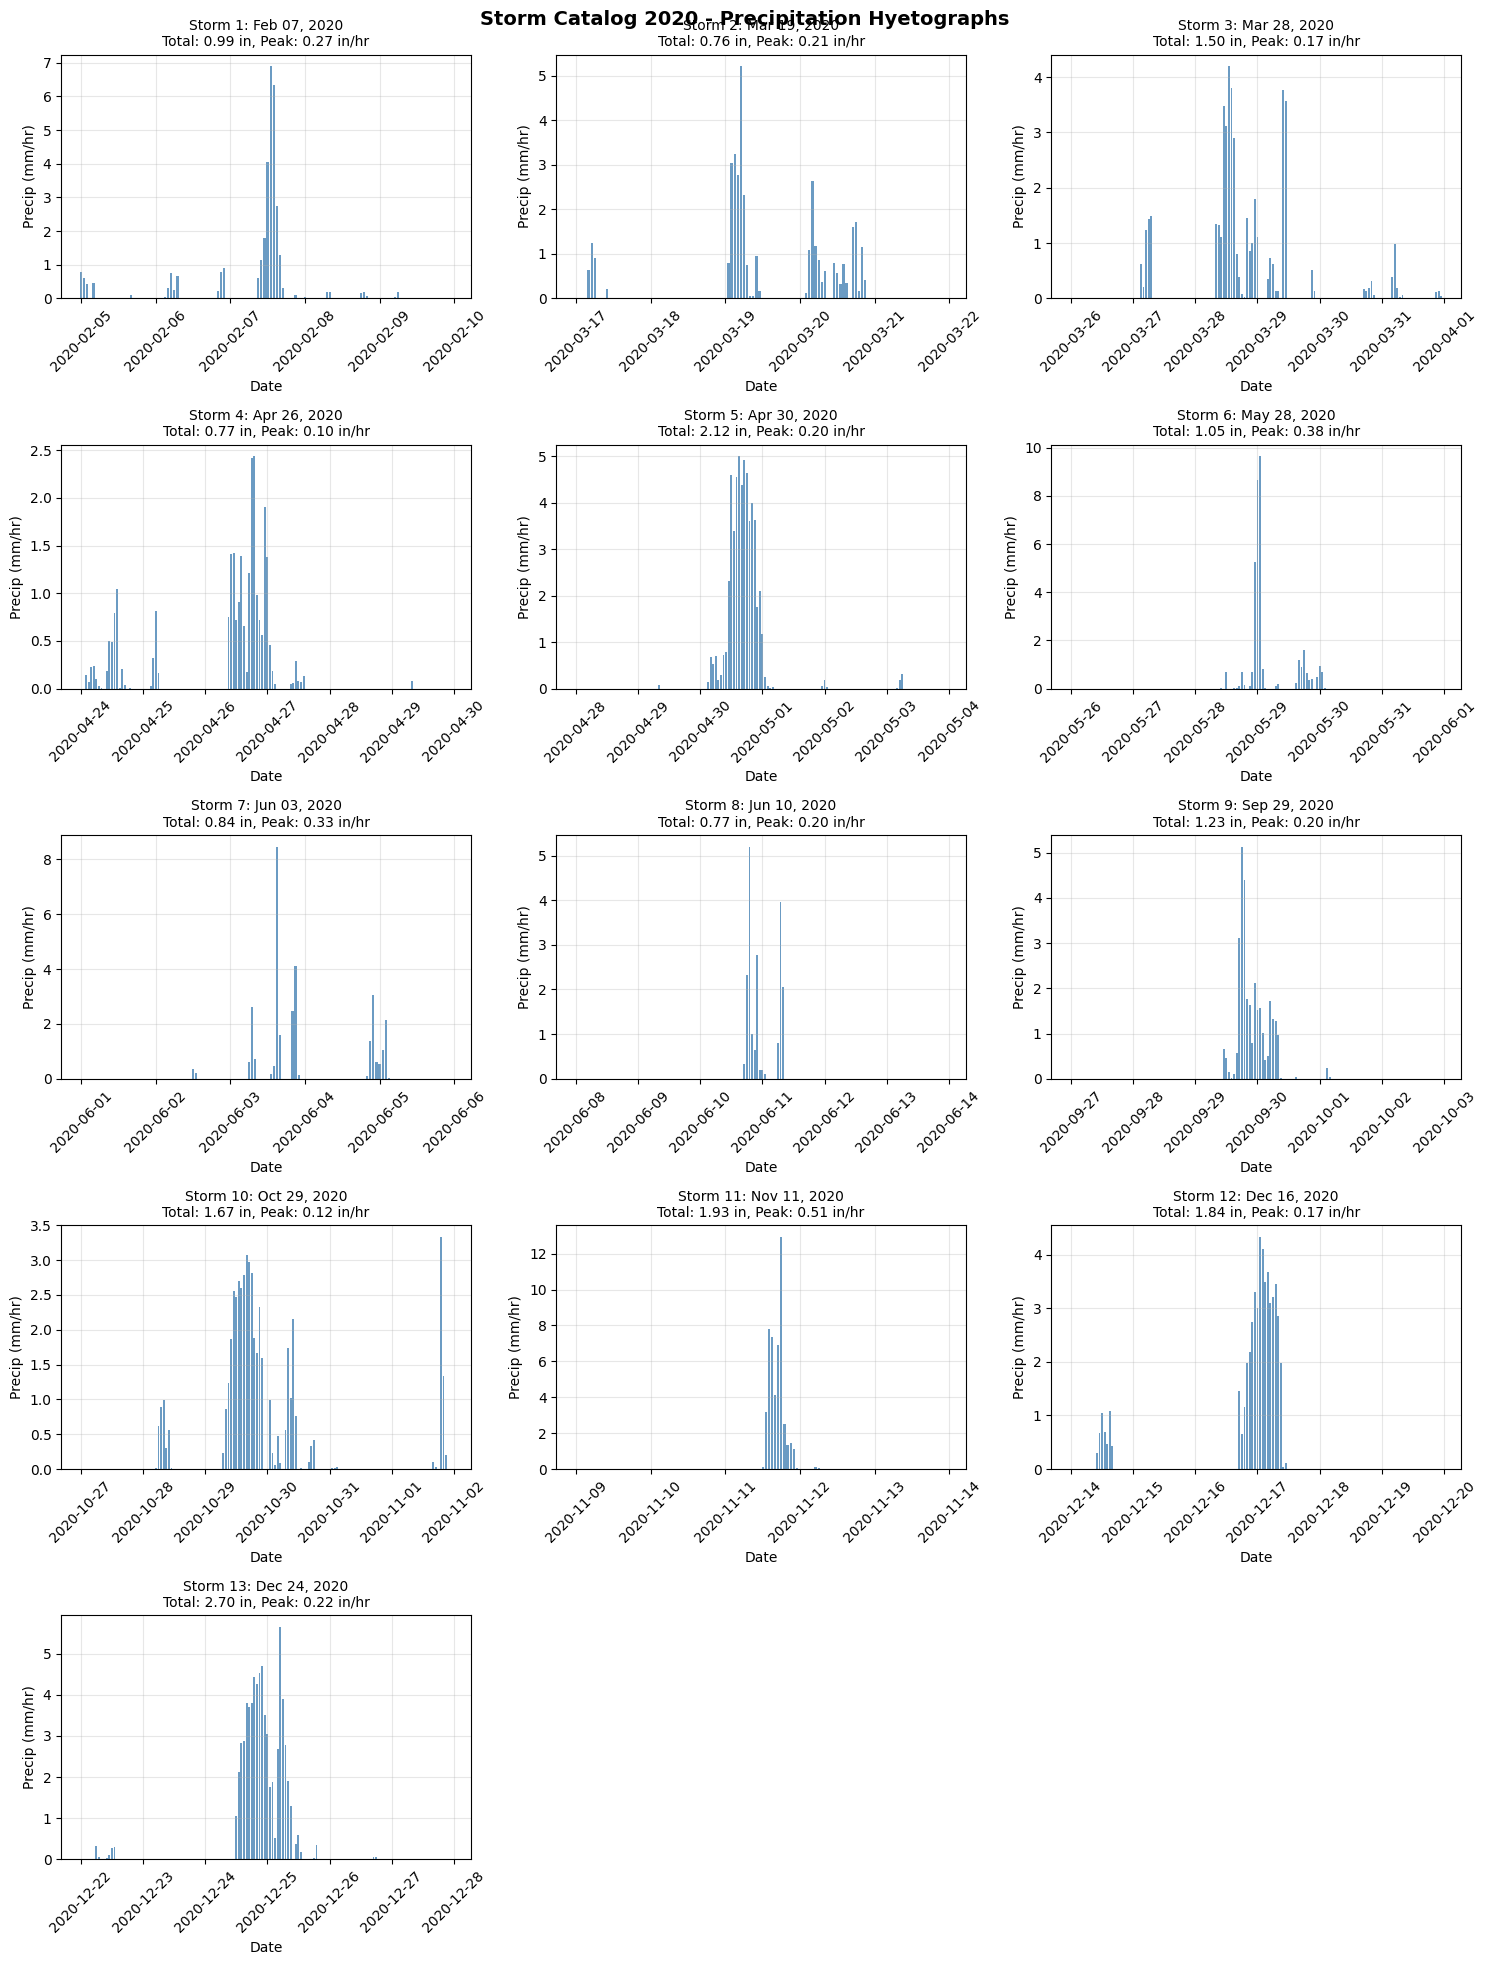

In [7]:
# Plot precipitation hyetographs for each storm
n_storms = len(storm_catalog)
n_cols = 3
n_rows = (n_storms + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
axes = axes.flatten() if n_storms > 1 else [axes]

for idx, (_, storm) in enumerate(storm_catalog.iterrows()):
    storm_id = storm['storm_id']
    precip_file = precip_files[storm_id]
    
    # Load precipitation data
    ds = xr.open_dataset(precip_file)
    da = ds['APCP_surface']
    
    # Calculate spatial mean
    hourly_mean = da.mean(dim=['x', 'y']).values
    times = pd.to_datetime(da.time.values)
    
    # Plot
    ax = axes[idx]
    ax.bar(times, hourly_mean, width=0.03, color='steelblue', alpha=0.8)
    ax.set_title(f"Storm {storm_id}: {storm['start_time'].strftime('%b %d, %Y')}\n"
                 f"Total: {storm['total_depth_in']:.2f} in, Peak: {storm['peak_intensity_in_hr']:.2f} in/hr",
                 fontsize=10)
    ax.set_xlabel('Date')
    ax.set_ylabel('Precip (mm/hr)')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)
    
    ds.close()

# Hide empty subplots
for idx in range(n_storms, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle(f'Storm Catalog {year} - Precipitation Hyetographs', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Step 4: Create HEC-RAS Plans for All Storms

Use `create_storm_plans()` to automatically create plan and unsteady files for each storm event.

In [8]:
# Create storm plans for all events
print(f"Creating HEC-RAS plans for {len(storm_catalog)} storms...")
print("="*60)

results = PrecipAorc.create_storm_plans(
    storm_catalog=storm_catalog,
    bounds=bounds,
    template_plan=template_plan,
    precip_folder="Precipitation",
    ras_object=ras,
    download_data=False  # Already downloaded above
)

print(f"\nPlan Creation Results:")
print(results[['storm_id', 'start_time', 'total_depth_in', 'plan_number', 'unsteady_number', 'status']].to_string(index=False))

2025-12-05 19:05:23 - ras_commander.precip.PrecipAorc - INFO - Creating storm plans from template plan 06 (unsteady 03)


2025-12-05 19:05:23 - ras_commander.precip.PrecipAorc - INFO -   Precipitation folder: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\Precipitation


2025-12-05 19:05:23 - ras_commander.precip.PrecipAorc - INFO -   Processing 13 storms


2025-12-05 19:05:23 - ras_commander.precip.PrecipAorc - INFO - Storm 1: 2020-02-07 (0.99 in)


2025-12-05 19:05:23 - ras_commander.precip.PrecipAorc - INFO -   Cloning unsteady file...


2025-12-05 19:05:23 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u03 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u04


2025-12-05 19:05:23 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u04


2025-12-05 19:05:23 - ras_commander.RasUtils - INFO - Project file updated with new Unsteady entry: 04


2025-12-05 19:05:23 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.rasmap


2025-12-05 19:05:23 - ras_commander.precip.PrecipAorc - INFO -   Configuring gridded precipitation...


2025-12-05 19:05:23 - ras_commander.RasUnsteady - INFO - Configuring gridded precipitation in C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u04


2025-12-05 19:05:23 - ras_commander.RasUnsteady - INFO -   NetCDF file: .\Precipitation\storm_20200207.nc


2025-12-05 19:05:23 - ras_commander.RasUnsteady - INFO -   Interpolation: Bilinear


2025-12-05 19:05:23 - ras_commander.RasUnsteady - INFO - Successfully configured gridded precipitation in C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u04


2025-12-05 19:05:23 - ras_commander.RasUnsteady - INFO - Updating precipitation in HDF: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u04.hdf


2025-12-05 19:05:23 - ras_commander.RasUnsteady - INFO -   NetCDF: 120 timesteps, 16x22 grid


2025-12-05 19:05:23 - ras_commander.RasUnsteady - INFO -   Imported 120 timesteps of raster data


2025-12-05 19:05:23 - ras_commander.precip.PrecipAorc - INFO -   Cloning plan file...


2025-12-05 19:05:23 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p07


2025-12-05 19:05:23 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p07


2025-12-05 19:05:23 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 07


2025-12-05 19:05:23 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.rasmap


2025-12-05 19:05:23 - ras_commander.RasPlan - INFO - Updated simulation date in plan file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p07


2025-12-05 19:05:23 - ras_commander.precip.PrecipAorc - INFO -   Enabled HDF time series output


2025-12-05 19:05:23 - ras_commander.precip.PrecipAorc - INFO -   Created plan 07 with unsteady 04


2025-12-05 19:05:23 - ras_commander.precip.PrecipAorc - INFO - Storm 2: 2020-03-19 (0.76 in)


2025-12-05 19:05:23 - ras_commander.precip.PrecipAorc - INFO -   Cloning unsteady file...


2025-12-05 19:05:23 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u03 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u05


2025-12-05 19:05:23 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u05


2025-12-05 19:05:23 - ras_commander.RasUtils - INFO - Project file updated with new Unsteady entry: 05


Creating HEC-RAS plans for 13 storms...


2025-12-05 19:05:23 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.rasmap


2025-12-05 19:05:23 - ras_commander.precip.PrecipAorc - INFO -   Configuring gridded precipitation...


2025-12-05 19:05:23 - ras_commander.RasUnsteady - INFO - Configuring gridded precipitation in C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u05


2025-12-05 19:05:23 - ras_commander.RasUnsteady - INFO -   NetCDF file: .\Precipitation\storm_20200319.nc


2025-12-05 19:05:23 - ras_commander.RasUnsteady - INFO -   Interpolation: Bilinear


2025-12-05 19:05:23 - ras_commander.RasUnsteady - INFO - Successfully configured gridded precipitation in C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u05


2025-12-05 19:05:23 - ras_commander.RasUnsteady - INFO - Updating precipitation in HDF: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u05.hdf


2025-12-05 19:05:23 - ras_commander.RasUnsteady - INFO -   NetCDF: 120 timesteps, 16x22 grid


2025-12-05 19:05:23 - ras_commander.RasUnsteady - INFO -   Imported 120 timesteps of raster data


2025-12-05 19:05:23 - ras_commander.precip.PrecipAorc - INFO -   Cloning plan file...


2025-12-05 19:05:23 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p08


2025-12-05 19:05:23 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p08


2025-12-05 19:05:23 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 08


2025-12-05 19:05:23 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.rasmap


2025-12-05 19:05:23 - ras_commander.RasPlan - INFO - Updated simulation date in plan file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p08


2025-12-05 19:05:23 - ras_commander.precip.PrecipAorc - INFO -   Enabled HDF time series output


2025-12-05 19:05:23 - ras_commander.precip.PrecipAorc - INFO -   Created plan 08 with unsteady 05


2025-12-05 19:05:23 - ras_commander.precip.PrecipAorc - INFO - Storm 3: 2020-03-28 (1.50 in)


2025-12-05 19:05:23 - ras_commander.precip.PrecipAorc - INFO -   Cloning unsteady file...


2025-12-05 19:05:23 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u03 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u06


2025-12-05 19:05:23 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u06


2025-12-05 19:05:23 - ras_commander.RasUtils - INFO - Project file updated with new Unsteady entry: 06


2025-12-05 19:05:23 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.rasmap


2025-12-05 19:05:23 - ras_commander.precip.PrecipAorc - INFO -   Configuring gridded precipitation...


2025-12-05 19:05:23 - ras_commander.RasUnsteady - INFO - Configuring gridded precipitation in C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u06


2025-12-05 19:05:23 - ras_commander.RasUnsteady - INFO -   NetCDF file: .\Precipitation\storm_20200328.nc


2025-12-05 19:05:23 - ras_commander.RasUnsteady - INFO -   Interpolation: Bilinear


2025-12-05 19:05:23 - ras_commander.RasUnsteady - INFO - Successfully configured gridded precipitation in C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u06


2025-12-05 19:05:23 - ras_commander.RasUnsteady - INFO - Updating precipitation in HDF: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u06.hdf


2025-12-05 19:05:23 - ras_commander.RasUnsteady - INFO -   NetCDF: 144 timesteps, 16x22 grid


2025-12-05 19:05:23 - ras_commander.RasUnsteady - INFO -   Imported 144 timesteps of raster data


2025-12-05 19:05:23 - ras_commander.precip.PrecipAorc - INFO -   Cloning plan file...


2025-12-05 19:05:23 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p09


2025-12-05 19:05:23 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p09


2025-12-05 19:05:23 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 09


2025-12-05 19:05:23 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.rasmap


2025-12-05 19:05:23 - ras_commander.RasPlan - INFO - Updated simulation date in plan file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p09


2025-12-05 19:05:23 - ras_commander.precip.PrecipAorc - INFO -   Enabled HDF time series output


2025-12-05 19:05:23 - ras_commander.precip.PrecipAorc - INFO -   Created plan 09 with unsteady 06


2025-12-05 19:05:23 - ras_commander.precip.PrecipAorc - INFO - Storm 4: 2020-04-26 (0.77 in)


2025-12-05 19:05:23 - ras_commander.precip.PrecipAorc - INFO -   Cloning unsteady file...


2025-12-05 19:05:23 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u03 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u14


2025-12-05 19:05:23 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u14


2025-12-05 19:05:23 - ras_commander.RasUtils - INFO - Project file updated with new Unsteady entry: 14


2025-12-05 19:05:24 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.rasmap


2025-12-05 19:05:24 - ras_commander.precip.PrecipAorc - INFO -   Configuring gridded precipitation...


2025-12-05 19:05:24 - ras_commander.RasUnsteady - INFO - Configuring gridded precipitation in C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u14


2025-12-05 19:05:24 - ras_commander.RasUnsteady - INFO -   NetCDF file: .\Precipitation\storm_20200426.nc


2025-12-05 19:05:24 - ras_commander.RasUnsteady - INFO -   Interpolation: Bilinear


2025-12-05 19:05:24 - ras_commander.RasUnsteady - INFO - Successfully configured gridded precipitation in C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u14


2025-12-05 19:05:24 - ras_commander.RasUnsteady - INFO - Updating precipitation in HDF: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u14.hdf


2025-12-05 19:05:24 - ras_commander.RasUnsteady - INFO -   NetCDF: 144 timesteps, 16x22 grid


2025-12-05 19:05:24 - ras_commander.RasUnsteady - INFO -   Imported 144 timesteps of raster data


2025-12-05 19:05:24 - ras_commander.precip.PrecipAorc - INFO -   Cloning plan file...


2025-12-05 19:05:24 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p10


2025-12-05 19:05:24 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p10


2025-12-05 19:05:24 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 10


2025-12-05 19:05:24 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.rasmap


2025-12-05 19:05:24 - ras_commander.RasPlan - INFO - Updated simulation date in plan file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p10


2025-12-05 19:05:24 - ras_commander.precip.PrecipAorc - INFO -   Enabled HDF time series output


2025-12-05 19:05:24 - ras_commander.precip.PrecipAorc - INFO -   Created plan 10 with unsteady 14


2025-12-05 19:05:24 - ras_commander.precip.PrecipAorc - INFO - Storm 5: 2020-04-30 (2.12 in)


2025-12-05 19:05:24 - ras_commander.precip.PrecipAorc - INFO -   Cloning unsteady file...


2025-12-05 19:05:24 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u03 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u15


2025-12-05 19:05:24 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u15


2025-12-05 19:05:24 - ras_commander.RasUtils - INFO - Project file updated with new Unsteady entry: 15


2025-12-05 19:05:24 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.rasmap


2025-12-05 19:05:24 - ras_commander.precip.PrecipAorc - INFO -   Configuring gridded precipitation...


2025-12-05 19:05:24 - ras_commander.RasUnsteady - INFO - Configuring gridded precipitation in C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u15


2025-12-05 19:05:24 - ras_commander.RasUnsteady - INFO -   NetCDF file: .\Precipitation\storm_20200430.nc


2025-12-05 19:05:24 - ras_commander.RasUnsteady - INFO -   Interpolation: Bilinear


2025-12-05 19:05:24 - ras_commander.RasUnsteady - INFO - Successfully configured gridded precipitation in C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u15


2025-12-05 19:05:24 - ras_commander.RasUnsteady - INFO - Updating precipitation in HDF: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u15.hdf


2025-12-05 19:05:24 - ras_commander.RasUnsteady - INFO -   NetCDF: 144 timesteps, 16x22 grid


2025-12-05 19:05:24 - ras_commander.RasUnsteady - INFO -   Imported 144 timesteps of raster data


2025-12-05 19:05:24 - ras_commander.precip.PrecipAorc - INFO -   Cloning plan file...


2025-12-05 19:05:24 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p11


2025-12-05 19:05:24 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p11


2025-12-05 19:05:24 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 11


2025-12-05 19:05:24 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.rasmap


2025-12-05 19:05:24 - ras_commander.RasPlan - INFO - Updated simulation date in plan file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p11


2025-12-05 19:05:24 - ras_commander.precip.PrecipAorc - INFO -   Enabled HDF time series output


2025-12-05 19:05:24 - ras_commander.precip.PrecipAorc - INFO -   Created plan 11 with unsteady 15


2025-12-05 19:05:24 - ras_commander.precip.PrecipAorc - INFO - Storm 6: 2020-05-28 (1.05 in)


2025-12-05 19:05:24 - ras_commander.precip.PrecipAorc - INFO -   Cloning unsteady file...


2025-12-05 19:05:24 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u03 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u16


2025-12-05 19:05:24 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u16


2025-12-05 19:05:24 - ras_commander.RasUtils - INFO - Project file updated with new Unsteady entry: 16


2025-12-05 19:05:24 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.rasmap


2025-12-05 19:05:24 - ras_commander.precip.PrecipAorc - INFO -   Configuring gridded precipitation...


2025-12-05 19:05:24 - ras_commander.RasUnsteady - INFO - Configuring gridded precipitation in C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u16


2025-12-05 19:05:24 - ras_commander.RasUnsteady - INFO -   NetCDF file: .\Precipitation\storm_20200528.nc


2025-12-05 19:05:24 - ras_commander.RasUnsteady - INFO -   Interpolation: Bilinear


2025-12-05 19:05:24 - ras_commander.RasUnsteady - INFO - Successfully configured gridded precipitation in C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u16


2025-12-05 19:05:24 - ras_commander.RasUnsteady - INFO - Updating precipitation in HDF: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u16.hdf


2025-12-05 19:05:24 - ras_commander.RasUnsteady - INFO -   NetCDF: 144 timesteps, 16x22 grid


2025-12-05 19:05:24 - ras_commander.RasUnsteady - INFO -   Imported 144 timesteps of raster data


2025-12-05 19:05:24 - ras_commander.precip.PrecipAorc - INFO -   Cloning plan file...


2025-12-05 19:05:24 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p12


2025-12-05 19:05:24 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p12


2025-12-05 19:05:24 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 12


2025-12-05 19:05:24 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.rasmap


2025-12-05 19:05:24 - ras_commander.RasPlan - INFO - Updated simulation date in plan file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p12


2025-12-05 19:05:24 - ras_commander.precip.PrecipAorc - INFO -   Enabled HDF time series output


2025-12-05 19:05:24 - ras_commander.precip.PrecipAorc - INFO -   Created plan 12 with unsteady 16


2025-12-05 19:05:24 - ras_commander.precip.PrecipAorc - INFO - Storm 7: 2020-06-03 (0.84 in)


2025-12-05 19:05:24 - ras_commander.precip.PrecipAorc - INFO -   Cloning unsteady file...


2025-12-05 19:05:24 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u03 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u17


2025-12-05 19:05:24 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u17


2025-12-05 19:05:24 - ras_commander.RasUtils - INFO - Project file updated with new Unsteady entry: 17


2025-12-05 19:05:24 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.rasmap


2025-12-05 19:05:24 - ras_commander.precip.PrecipAorc - INFO -   Configuring gridded precipitation...


2025-12-05 19:05:24 - ras_commander.RasUnsteady - INFO - Configuring gridded precipitation in C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u17


2025-12-05 19:05:24 - ras_commander.RasUnsteady - INFO -   NetCDF file: .\Precipitation\storm_20200603.nc


2025-12-05 19:05:24 - ras_commander.RasUnsteady - INFO -   Interpolation: Bilinear


2025-12-05 19:05:24 - ras_commander.RasUnsteady - INFO - Successfully configured gridded precipitation in C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u17


2025-12-05 19:05:24 - ras_commander.RasUnsteady - INFO - Updating precipitation in HDF: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u17.hdf


2025-12-05 19:05:24 - ras_commander.RasUnsteady - INFO -   NetCDF: 120 timesteps, 16x22 grid


2025-12-05 19:05:24 - ras_commander.RasUnsteady - INFO -   Imported 120 timesteps of raster data


2025-12-05 19:05:24 - ras_commander.precip.PrecipAorc - INFO -   Cloning plan file...


2025-12-05 19:05:24 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p14


2025-12-05 19:05:24 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p14


2025-12-05 19:05:24 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 14


2025-12-05 19:05:24 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.rasmap


2025-12-05 19:05:24 - ras_commander.RasPlan - INFO - Updated simulation date in plan file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p14


2025-12-05 19:05:24 - ras_commander.precip.PrecipAorc - INFO -   Enabled HDF time series output


2025-12-05 19:05:24 - ras_commander.precip.PrecipAorc - INFO -   Created plan 14 with unsteady 17


2025-12-05 19:05:24 - ras_commander.precip.PrecipAorc - INFO - Storm 8: 2020-06-10 (0.77 in)


2025-12-05 19:05:24 - ras_commander.precip.PrecipAorc - INFO -   Cloning unsteady file...


2025-12-05 19:05:24 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u03 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u18


2025-12-05 19:05:24 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u18


2025-12-05 19:05:24 - ras_commander.RasUtils - INFO - Project file updated with new Unsteady entry: 18


2025-12-05 19:05:24 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.rasmap


2025-12-05 19:05:24 - ras_commander.precip.PrecipAorc - INFO -   Configuring gridded precipitation...


2025-12-05 19:05:24 - ras_commander.RasUnsteady - INFO - Configuring gridded precipitation in C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u18


2025-12-05 19:05:24 - ras_commander.RasUnsteady - INFO -   NetCDF file: .\Precipitation\storm_20200610.nc


2025-12-05 19:05:24 - ras_commander.RasUnsteady - INFO -   Interpolation: Bilinear


2025-12-05 19:05:24 - ras_commander.RasUnsteady - INFO - Successfully configured gridded precipitation in C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u18


2025-12-05 19:05:24 - ras_commander.RasUnsteady - INFO - Updating precipitation in HDF: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u18.hdf


2025-12-05 19:05:24 - ras_commander.RasUnsteady - INFO -   NetCDF: 144 timesteps, 16x22 grid


2025-12-05 19:05:24 - ras_commander.RasUnsteady - INFO -   Imported 144 timesteps of raster data


2025-12-05 19:05:24 - ras_commander.precip.PrecipAorc - INFO -   Cloning plan file...


2025-12-05 19:05:24 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p16


2025-12-05 19:05:24 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p16


2025-12-05 19:05:24 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 16


2025-12-05 19:05:24 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.rasmap


2025-12-05 19:05:24 - ras_commander.RasPlan - INFO - Updated simulation date in plan file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p16


2025-12-05 19:05:24 - ras_commander.precip.PrecipAorc - INFO -   Enabled HDF time series output


2025-12-05 19:05:25 - ras_commander.precip.PrecipAorc - INFO -   Created plan 16 with unsteady 18


2025-12-05 19:05:25 - ras_commander.precip.PrecipAorc - INFO - Storm 9: 2020-09-29 (1.23 in)


2025-12-05 19:05:25 - ras_commander.precip.PrecipAorc - INFO -   Cloning unsteady file...


2025-12-05 19:05:25 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u03 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u19


2025-12-05 19:05:25 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u19


2025-12-05 19:05:25 - ras_commander.RasUtils - INFO - Project file updated with new Unsteady entry: 19


2025-12-05 19:05:25 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.rasmap


2025-12-05 19:05:25 - ras_commander.precip.PrecipAorc - INFO -   Configuring gridded precipitation...


2025-12-05 19:05:25 - ras_commander.RasUnsteady - INFO - Configuring gridded precipitation in C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u19


2025-12-05 19:05:25 - ras_commander.RasUnsteady - INFO -   NetCDF file: .\Precipitation\storm_20200929.nc


2025-12-05 19:05:25 - ras_commander.RasUnsteady - INFO -   Interpolation: Bilinear


2025-12-05 19:05:25 - ras_commander.RasUnsteady - INFO - Successfully configured gridded precipitation in C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u19


2025-12-05 19:05:25 - ras_commander.RasUnsteady - INFO - Updating precipitation in HDF: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u19.hdf


2025-12-05 19:05:25 - ras_commander.RasUnsteady - INFO -   NetCDF: 144 timesteps, 16x22 grid


2025-12-05 19:05:25 - ras_commander.RasUnsteady - INFO -   Imported 144 timesteps of raster data


2025-12-05 19:05:25 - ras_commander.precip.PrecipAorc - INFO -   Cloning plan file...


2025-12-05 19:05:25 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p20


2025-12-05 19:05:25 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p20


2025-12-05 19:05:25 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 20


2025-12-05 19:05:25 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.rasmap


2025-12-05 19:05:25 - ras_commander.RasPlan - INFO - Updated simulation date in plan file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p20


2025-12-05 19:05:25 - ras_commander.precip.PrecipAorc - INFO -   Enabled HDF time series output


2025-12-05 19:05:25 - ras_commander.precip.PrecipAorc - INFO -   Created plan 20 with unsteady 19


2025-12-05 19:05:25 - ras_commander.precip.PrecipAorc - INFO - Storm 10: 2020-10-29 (1.67 in)


2025-12-05 19:05:25 - ras_commander.precip.PrecipAorc - INFO -   Cloning unsteady file...


2025-12-05 19:05:25 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u03 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u20


2025-12-05 19:05:25 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u20


2025-12-05 19:05:25 - ras_commander.RasUtils - INFO - Project file updated with new Unsteady entry: 20


2025-12-05 19:05:25 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.rasmap


2025-12-05 19:05:25 - ras_commander.precip.PrecipAorc - INFO -   Configuring gridded precipitation...


2025-12-05 19:05:25 - ras_commander.RasUnsteady - INFO - Configuring gridded precipitation in C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u20


2025-12-05 19:05:25 - ras_commander.RasUnsteady - INFO -   NetCDF file: .\Precipitation\storm_20201029.nc


2025-12-05 19:05:25 - ras_commander.RasUnsteady - INFO -   Interpolation: Bilinear


2025-12-05 19:05:25 - ras_commander.RasUnsteady - INFO - Successfully configured gridded precipitation in C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u20


2025-12-05 19:05:25 - ras_commander.RasUnsteady - INFO - Updating precipitation in HDF: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u20.hdf


2025-12-05 19:05:25 - ras_commander.RasUnsteady - INFO -   NetCDF: 144 timesteps, 16x22 grid


2025-12-05 19:05:25 - ras_commander.RasUnsteady - INFO -   Imported 144 timesteps of raster data


2025-12-05 19:05:25 - ras_commander.precip.PrecipAorc - INFO -   Cloning plan file...


2025-12-05 19:05:25 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p21


2025-12-05 19:05:25 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p21


2025-12-05 19:05:25 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 21


2025-12-05 19:05:25 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.rasmap


2025-12-05 19:05:25 - ras_commander.RasPlan - INFO - Updated simulation date in plan file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p21


2025-12-05 19:05:25 - ras_commander.precip.PrecipAorc - INFO -   Enabled HDF time series output


2025-12-05 19:05:25 - ras_commander.precip.PrecipAorc - INFO -   Created plan 21 with unsteady 20


2025-12-05 19:05:25 - ras_commander.precip.PrecipAorc - INFO - Storm 11: 2020-11-11 (1.93 in)


2025-12-05 19:05:25 - ras_commander.precip.PrecipAorc - INFO -   Cloning unsteady file...


2025-12-05 19:05:25 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u03 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u21


2025-12-05 19:05:25 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u21


2025-12-05 19:05:25 - ras_commander.RasUtils - INFO - Project file updated with new Unsteady entry: 21


2025-12-05 19:05:25 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.rasmap


2025-12-05 19:05:25 - ras_commander.precip.PrecipAorc - INFO -   Configuring gridded precipitation...


2025-12-05 19:05:25 - ras_commander.RasUnsteady - INFO - Configuring gridded precipitation in C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u21


2025-12-05 19:05:25 - ras_commander.RasUnsteady - INFO -   NetCDF file: .\Precipitation\storm_20201111.nc


2025-12-05 19:05:25 - ras_commander.RasUnsteady - INFO -   Interpolation: Bilinear


2025-12-05 19:05:25 - ras_commander.RasUnsteady - INFO - Successfully configured gridded precipitation in C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u21


2025-12-05 19:05:25 - ras_commander.RasUnsteady - INFO - Updating precipitation in HDF: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u21.hdf


2025-12-05 19:05:25 - ras_commander.RasUnsteady - INFO -   NetCDF: 120 timesteps, 16x22 grid


2025-12-05 19:05:25 - ras_commander.RasUnsteady - INFO -   Imported 120 timesteps of raster data


2025-12-05 19:05:25 - ras_commander.precip.PrecipAorc - INFO -   Cloning plan file...


2025-12-05 19:05:25 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p22


2025-12-05 19:05:25 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p22


2025-12-05 19:05:25 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 22


2025-12-05 19:05:25 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.rasmap


2025-12-05 19:05:25 - ras_commander.RasPlan - INFO - Updated simulation date in plan file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p22


2025-12-05 19:05:25 - ras_commander.precip.PrecipAorc - INFO -   Enabled HDF time series output


2025-12-05 19:05:25 - ras_commander.precip.PrecipAorc - INFO -   Created plan 22 with unsteady 21


2025-12-05 19:05:25 - ras_commander.precip.PrecipAorc - INFO - Storm 12: 2020-12-16 (1.84 in)


2025-12-05 19:05:25 - ras_commander.precip.PrecipAorc - INFO -   Cloning unsteady file...


2025-12-05 19:05:25 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u03 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u22


2025-12-05 19:05:25 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u22


2025-12-05 19:05:25 - ras_commander.RasUtils - INFO - Project file updated with new Unsteady entry: 22


2025-12-05 19:05:25 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.rasmap


2025-12-05 19:05:25 - ras_commander.precip.PrecipAorc - INFO -   Configuring gridded precipitation...


2025-12-05 19:05:25 - ras_commander.RasUnsteady - INFO - Configuring gridded precipitation in C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u22


2025-12-05 19:05:25 - ras_commander.RasUnsteady - INFO -   NetCDF file: .\Precipitation\storm_20201216.nc


2025-12-05 19:05:25 - ras_commander.RasUnsteady - INFO -   Interpolation: Bilinear


2025-12-05 19:05:25 - ras_commander.RasUnsteady - INFO - Successfully configured gridded precipitation in C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u22


2025-12-05 19:05:25 - ras_commander.RasUnsteady - INFO - Updating precipitation in HDF: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u22.hdf


2025-12-05 19:05:25 - ras_commander.RasUnsteady - INFO -   NetCDF: 144 timesteps, 16x22 grid


2025-12-05 19:05:25 - ras_commander.RasUnsteady - INFO -   Imported 144 timesteps of raster data


2025-12-05 19:05:25 - ras_commander.precip.PrecipAorc - INFO -   Cloning plan file...


2025-12-05 19:05:25 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p23


2025-12-05 19:05:25 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p23


2025-12-05 19:05:25 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 23


2025-12-05 19:05:25 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.rasmap


2025-12-05 19:05:25 - ras_commander.RasPlan - INFO - Updated simulation date in plan file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p23


2025-12-05 19:05:25 - ras_commander.precip.PrecipAorc - INFO -   Enabled HDF time series output


2025-12-05 19:05:25 - ras_commander.precip.PrecipAorc - INFO -   Created plan 23 with unsteady 22


2025-12-05 19:05:25 - ras_commander.precip.PrecipAorc - INFO - Storm 13: 2020-12-24 (2.70 in)


2025-12-05 19:05:25 - ras_commander.precip.PrecipAorc - INFO -   Cloning unsteady file...


2025-12-05 19:05:25 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u03 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u23


2025-12-05 19:05:25 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u23


2025-12-05 19:05:25 - ras_commander.RasUtils - INFO - Project file updated with new Unsteady entry: 23


2025-12-05 19:05:25 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.rasmap


2025-12-05 19:05:26 - ras_commander.precip.PrecipAorc - INFO -   Configuring gridded precipitation...


2025-12-05 19:05:26 - ras_commander.RasUnsteady - INFO - Configuring gridded precipitation in C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u23


2025-12-05 19:05:26 - ras_commander.RasUnsteady - INFO -   NetCDF file: .\Precipitation\storm_20201224.nc


2025-12-05 19:05:26 - ras_commander.RasUnsteady - INFO -   Interpolation: Bilinear


2025-12-05 19:05:26 - ras_commander.RasUnsteady - INFO - Successfully configured gridded precipitation in C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u23


2025-12-05 19:05:26 - ras_commander.RasUnsteady - INFO - Updating precipitation in HDF: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.u23.hdf


2025-12-05 19:05:26 - ras_commander.RasUnsteady - INFO -   NetCDF: 144 timesteps, 16x22 grid


2025-12-05 19:05:26 - ras_commander.RasUnsteady - INFO -   Imported 144 timesteps of raster data


2025-12-05 19:05:26 - ras_commander.precip.PrecipAorc - INFO -   Cloning plan file...


2025-12-05 19:05:26 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p24


2025-12-05 19:05:26 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p24


2025-12-05 19:05:26 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 24


2025-12-05 19:05:26 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.rasmap


2025-12-05 19:05:26 - ras_commander.RasPlan - INFO - Updated simulation date in plan file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p24


2025-12-05 19:05:26 - ras_commander.precip.PrecipAorc - INFO -   Enabled HDF time series output


2025-12-05 19:05:26 - ras_commander.precip.PrecipAorc - INFO -   Created plan 24 with unsteady 23


2025-12-05 19:05:26 - ras_commander.precip.PrecipAorc - INFO - Storm plan creation complete: 13/13 successful



Plan Creation Results:
 storm_id          start_time  total_depth_in plan_number unsteady_number  status
        1 2020-02-07 09:00:00           0.991          07              04 success
        2 2020-03-19 01:00:00           0.757          08              05 success
        3 2020-03-28 08:00:00           1.498          09              06 success
        4 2020-04-26 09:00:00           0.770          10              14 success
        5 2020-04-30 04:00:00           2.120          11              15 success
        6 2020-05-28 12:00:00           1.054          12              16 success
        7 2020-06-03 06:00:00           0.838          14              17 success
        8 2020-06-10 17:00:00           0.772          16              18 success
        9 2020-09-29 11:00:00           1.231          20              19 success
       10 2020-10-29 08:00:00           1.669          21              20 success
       11 2020-11-11 13:00:00           1.926          22              21 

In [9]:
# Verify created plans
ras.plan_df = ras.get_plan_entries()
print(f"\nTotal Plans: {len(ras.plan_df)}")
print("\nStorm Plans Created:")
storm_plans = ras.plan_df[ras.plan_df['Short Identifier'].str.startswith('Storm_')]
print(storm_plans[['plan_number', 'Short Identifier', 'Plan Title']].to_string(index=False))


Total Plans: 24

Storm Plans Created:
plan_number Short Identifier              Plan Title
         07       Storm_0207 AORC Storm Feb 07, 2020
         08       Storm_0319 AORC Storm Mar 19, 2020
         09       Storm_0328 AORC Storm Mar 28, 2020
         10       Storm_0426 AORC Storm Apr 26, 2020
         11       Storm_0430 AORC Storm Apr 30, 2020
         12       Storm_0528 AORC Storm May 28, 2020
         14       Storm_0603 AORC Storm Jun 03, 2020
         16       Storm_0610 AORC Storm Jun 10, 2020
         20       Storm_0929 AORC Storm Sep 29, 2020
         21       Storm_1029 AORC Storm Oct 29, 2020
         22       Storm_1111 AORC Storm Nov 11, 2020
         23       Storm_1216 AORC Storm Dec 16, 2020
         24       Storm_1224 AORC Storm Dec 24, 2020


## Step 5: Execute Storm Plans (Work In Progress)

**Note**: The execution of storm plans with AORC precipitation data requires additional HEC-RAS configuration. The current workflow:
1. Downloads AORC data to NetCDF format (working)
2. Creates plan and unsteady flow files (working)
3. **Integration of precipitation into HEC-RAS HDF event conditions (requires manual setup)**

For the precipitation to work in HEC-RAS, the project must be configured to:
- Use DSS precipitation files (requires NetCDF → DSS conversion), OR
- Use raster-based precipitation with proper meteorological boundary setup

The cells below demonstrate the execution workflow but may require manual HEC-RAS project configuration for precipitation to be processed correctly.

In [10]:
# Get list of storm plan numbers
storm_plan_numbers = results[results['status'] == 'success']['plan_number'].tolist()
print(f"Plans to execute: {storm_plan_numbers}")
print(f"\nExecuting {len(storm_plan_numbers)} storm plans...")
print("="*60)

Plans to execute: ['07', '08', '09', '10', '11', '12', '14', '16', '20', '21', '22', '23', '24']

Executing 13 storm plans...


In [11]:
# Run plans in parallel
# Note: Results are copied to "[Computed]" folder and ras object is updated
execution_results = RasCmdr.compute_parallel(
    plan_number=storm_plan_numbers,  # Note: parameter is plan_number (accepts list)
    max_workers=4,
    num_cores=4,
    ras_object=ras,
    overwrite_dest=True
)

# execution_results is a dict: {plan_number: success_bool}
print(f"\nExecution complete!")
print(f"Successful: {sum(1 for success in execution_results.values() if success)}")
print(f"Failed: {sum(1 for success in execution_results.values() if not success)}")
print(f"\nResults folder: {ras.project_folder}")

2025-12-05 19:05:26 - ras_commander.RasCmdr - INFO - Filtered plans to execute: ['07', '08', '09', '10', '11', '12', '14', '16', '20', '21', '22', '23', '24']


2025-12-05 19:05:26 - ras_commander.RasCmdr - INFO - Adjusted max_workers to 4 based on the number of plans: 13


2025-12-05 19:05:26 - ras_commander.RasCmdr - INFO - Created worker folder: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Worker 1]


2025-12-05 19:05:26 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Worker 1]\BaldEagleDamBrk.rasmap


2025-12-05 19:05:26 - ras_commander.RasCmdr - INFO - Created worker folder: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Worker 2]


2025-12-05 19:05:27 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Worker 2]\BaldEagleDamBrk.rasmap


2025-12-05 19:05:27 - ras_commander.RasCmdr - INFO - Created worker folder: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Worker 3]


2025-12-05 19:05:27 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Worker 3]\BaldEagleDamBrk.rasmap


2025-12-05 19:05:27 - ras_commander.RasCmdr - INFO - Created worker folder: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Worker 4]


2025-12-05 19:05:28 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Worker 4]\BaldEagleDamBrk.rasmap


2025-12-05 19:05:28 - ras_commander.RasCmdr - INFO - Using ras_object with project folder: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Worker 1]


2025-12-05 19:05:28 - ras_commander.RasCmdr - INFO - Using ras_object with project folder: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Worker 2]


2025-12-05 19:05:28 - ras_commander.RasCmdr - INFO - Using ras_object with project folder: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Worker 3]


2025-12-05 19:05:28 - ras_commander.RasCmdr - INFO - Using ras_object with project folder: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Worker 4]


2025-12-05 19:05:28 - ras_commander.RasUtils - INFO - Using provided plan file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Worker 2]\BaldEagleDamBrk.p08


2025-12-05 19:05:28 - ras_commander.RasUtils - INFO - Using provided plan file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Worker 3]\BaldEagleDamBrk.p09


2025-12-05 19:05:28 - ras_commander.RasUtils - INFO - Using provided plan file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Worker 4]\BaldEagleDamBrk.p10


2025-12-05 19:05:28 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Worker 2]\BaldEagleDamBrk.p08


2025-12-05 19:05:28 - ras_commander.RasUtils - INFO - Using provided plan file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Worker 1]\BaldEagleDamBrk.p07


2025-12-05 19:05:28 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Worker 3]\BaldEagleDamBrk.p09


2025-12-05 19:05:28 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Worker 4]\BaldEagleDamBrk.p10


2025-12-05 19:05:28 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Worker 1]\BaldEagleDamBrk.p07


2025-12-05 19:05:28 - ras_commander.RasCmdr - INFO - Set number of cores to 4 for plan: 07


2025-12-05 19:05:28 - ras_commander.RasCmdr - INFO - Set number of cores to 4 for plan: 09


2025-12-05 19:05:28 - ras_commander.RasCmdr - INFO - Running HEC-RAS from the Command Line:


2025-12-05 19:05:28 - ras_commander.RasCmdr - INFO - Running HEC-RAS from the Command Line:


2025-12-05 19:05:28 - ras_commander.RasCmdr - INFO - Set number of cores to 4 for plan: 08


2025-12-05 19:05:28 - ras_commander.RasCmdr - INFO - Running command: "C:\Program Files (x86)\HEC\HEC-RAS\6.6\Ras.exe" -c "C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Worker 1]\BaldEagleDamBrk.prj" "C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Worker 1]\BaldEagleDamBrk.p07"


2025-12-05 19:05:28 - ras_commander.RasCmdr - INFO - Set number of cores to 4 for plan: 10


2025-12-05 19:05:28 - ras_commander.RasCmdr - INFO - Running command: "C:\Program Files (x86)\HEC\HEC-RAS\6.6\Ras.exe" -c "C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Worker 3]\BaldEagleDamBrk.prj" "C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Worker 3]\BaldEagleDamBrk.p09"


2025-12-05 19:05:28 - ras_commander.RasCmdr - INFO - Running HEC-RAS from the Command Line:


2025-12-05 19:05:28 - ras_commander.RasCmdr - INFO - Running HEC-RAS from the Command Line:


2025-12-05 19:05:28 - ras_commander.RasCmdr - INFO - Running command: "C:\Program Files (x86)\HEC\HEC-RAS\6.6\Ras.exe" -c "C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Worker 2]\BaldEagleDamBrk.prj" "C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Worker 2]\BaldEagleDamBrk.p08"


2025-12-05 19:05:28 - ras_commander.RasCmdr - INFO - Running command: "C:\Program Files (x86)\HEC\HEC-RAS\6.6\Ras.exe" -c "C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Worker 4]\BaldEagleDamBrk.prj" "C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Worker 4]\BaldEagleDamBrk.p10"


2025-12-05 19:05:43 - ras_commander.RasCmdr - INFO - HEC-RAS execution completed for plan: 08


2025-12-05 19:05:43 - ras_commander.RasCmdr - INFO - Total run time for plan 08: 15.30 seconds


2025-12-05 19:05:43 - ras_commander.RasCmdr - INFO - Using ras_object with project folder: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Worker 1]


2025-12-05 19:05:43 - ras_commander.RasCmdr - INFO - Plan 07 executed in worker 1: Successful


2025-12-05 19:05:43 - ras_commander.RasUtils - INFO - Using provided plan file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Worker 1]\BaldEagleDamBrk.p11


2025-12-05 19:05:43 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Worker 1]\BaldEagleDamBrk.p11


2025-12-05 19:05:43 - ras_commander.RasCmdr - INFO - Set number of cores to 4 for plan: 11


2025-12-05 19:05:43 - ras_commander.RasCmdr - INFO - Running HEC-RAS from the Command Line:


2025-12-05 19:05:43 - ras_commander.RasCmdr - INFO - Running command: "C:\Program Files (x86)\HEC\HEC-RAS\6.6\Ras.exe" -c "C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Worker 1]\BaldEagleDamBrk.prj" "C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Worker 1]\BaldEagleDamBrk.p11"


2025-12-05 19:05:44 - ras_commander.RasCmdr - INFO - HEC-RAS execution completed for plan: 07


2025-12-05 19:05:44 - ras_commander.RasCmdr - INFO - Total run time for plan 07: 16.07 seconds


2025-12-05 19:05:44 - ras_commander.RasCmdr - INFO - Using ras_object with project folder: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Worker 2]


2025-12-05 19:05:44 - ras_commander.RasCmdr - INFO - Plan 08 executed in worker 2: Successful


2025-12-05 19:05:44 - ras_commander.RasUtils - INFO - Using provided plan file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Worker 2]\BaldEagleDamBrk.p12


2025-12-05 19:05:44 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Worker 2]\BaldEagleDamBrk.p12


2025-12-05 19:05:44 - ras_commander.RasCmdr - INFO - Set number of cores to 4 for plan: 12


2025-12-05 19:05:44 - ras_commander.RasCmdr - INFO - Running HEC-RAS from the Command Line:


2025-12-05 19:05:44 - ras_commander.RasCmdr - INFO - Running command: "C:\Program Files (x86)\HEC\HEC-RAS\6.6\Ras.exe" -c "C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Worker 2]\BaldEagleDamBrk.prj" "C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Worker 2]\BaldEagleDamBrk.p12"


2025-12-05 19:05:44 - ras_commander.RasCmdr - INFO - HEC-RAS execution completed for plan: 10


2025-12-05 19:05:44 - ras_commander.RasCmdr - INFO - Total run time for plan 10: 16.16 seconds


2025-12-05 19:05:44 - ras_commander.RasCmdr - INFO - Using ras_object with project folder: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Worker 3]


2025-12-05 19:05:44 - ras_commander.RasCmdr - INFO - Plan 09 executed in worker 3: Successful


2025-12-05 19:05:44 - ras_commander.RasUtils - INFO - Using provided plan file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Worker 3]\BaldEagleDamBrk.p14


2025-12-05 19:05:44 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Worker 3]\BaldEagleDamBrk.p14


2025-12-05 19:05:44 - ras_commander.RasCmdr - INFO - Set number of cores to 4 for plan: 14


2025-12-05 19:05:44 - ras_commander.RasCmdr - INFO - Running HEC-RAS from the Command Line:


2025-12-05 19:05:44 - ras_commander.RasCmdr - INFO - Running command: "C:\Program Files (x86)\HEC\HEC-RAS\6.6\Ras.exe" -c "C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Worker 3]\BaldEagleDamBrk.prj" "C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Worker 3]\BaldEagleDamBrk.p14"


2025-12-05 19:05:44 - ras_commander.RasCmdr - INFO - HEC-RAS execution completed for plan: 09


2025-12-05 19:05:44 - ras_commander.RasCmdr - INFO - Total run time for plan 09: 16.24 seconds


2025-12-05 19:05:44 - ras_commander.RasCmdr - INFO - Using ras_object with project folder: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Worker 4]


2025-12-05 19:05:44 - ras_commander.RasCmdr - INFO - Plan 10 executed in worker 4: Successful


2025-12-05 19:05:44 - ras_commander.RasUtils - INFO - Using provided plan file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Worker 4]\BaldEagleDamBrk.p16


2025-12-05 19:05:44 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Worker 4]\BaldEagleDamBrk.p16


2025-12-05 19:05:44 - ras_commander.RasCmdr - INFO - Set number of cores to 4 for plan: 16


2025-12-05 19:05:44 - ras_commander.RasCmdr - INFO - Running HEC-RAS from the Command Line:


2025-12-05 19:05:44 - ras_commander.RasCmdr - INFO - Running command: "C:\Program Files (x86)\HEC\HEC-RAS\6.6\Ras.exe" -c "C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Worker 4]\BaldEagleDamBrk.prj" "C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Worker 4]\BaldEagleDamBrk.p16"


2025-12-05 19:05:58 - ras_commander.RasCmdr - INFO - HEC-RAS execution completed for plan: 11


2025-12-05 19:05:58 - ras_commander.RasCmdr - INFO - Total run time for plan 11: 15.16 seconds


2025-12-05 19:05:58 - ras_commander.RasCmdr - INFO - Using ras_object with project folder: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Worker 1]


2025-12-05 19:05:58 - ras_commander.RasCmdr - INFO - Plan 11 executed in worker 1: Successful


2025-12-05 19:05:58 - ras_commander.RasUtils - INFO - Using provided plan file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Worker 1]\BaldEagleDamBrk.p20


2025-12-05 19:05:58 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Worker 1]\BaldEagleDamBrk.p20


2025-12-05 19:05:58 - ras_commander.RasCmdr - INFO - Set number of cores to 4 for plan: 20


2025-12-05 19:05:58 - ras_commander.RasCmdr - INFO - Running HEC-RAS from the Command Line:


2025-12-05 19:05:58 - ras_commander.RasCmdr - INFO - Running command: "C:\Program Files (x86)\HEC\HEC-RAS\6.6\Ras.exe" -c "C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Worker 1]\BaldEagleDamBrk.prj" "C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Worker 1]\BaldEagleDamBrk.p20"


2025-12-05 19:05:59 - ras_commander.RasCmdr - INFO - HEC-RAS execution completed for plan: 12


2025-12-05 19:05:59 - ras_commander.RasCmdr - INFO - Total run time for plan 12: 15.04 seconds


2025-12-05 19:05:59 - ras_commander.RasCmdr - INFO - Using ras_object with project folder: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Worker 2]


2025-12-05 19:05:59 - ras_commander.RasCmdr - INFO - Plan 12 executed in worker 2: Successful


2025-12-05 19:05:59 - ras_commander.RasUtils - INFO - Using provided plan file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Worker 2]\BaldEagleDamBrk.p21


2025-12-05 19:05:59 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Worker 2]\BaldEagleDamBrk.p21


2025-12-05 19:05:59 - ras_commander.RasCmdr - INFO - Set number of cores to 4 for plan: 21


2025-12-05 19:05:59 - ras_commander.RasCmdr - INFO - Running HEC-RAS from the Command Line:


2025-12-05 19:05:59 - ras_commander.RasCmdr - INFO - Running command: "C:\Program Files (x86)\HEC\HEC-RAS\6.6\Ras.exe" -c "C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Worker 2]\BaldEagleDamBrk.prj" "C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Worker 2]\BaldEagleDamBrk.p21"


2025-12-05 19:05:59 - ras_commander.RasCmdr - INFO - HEC-RAS execution completed for plan: 14


2025-12-05 19:05:59 - ras_commander.RasCmdr - INFO - Total run time for plan 14: 15.56 seconds


2025-12-05 19:05:59 - ras_commander.RasCmdr - INFO - Using ras_object with project folder: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Worker 3]


2025-12-05 19:05:59 - ras_commander.RasCmdr - INFO - Plan 14 executed in worker 3: Successful


2025-12-05 19:05:59 - ras_commander.RasUtils - INFO - Using provided plan file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Worker 3]\BaldEagleDamBrk.p22


2025-12-05 19:05:59 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Worker 3]\BaldEagleDamBrk.p22


2025-12-05 19:05:59 - ras_commander.RasCmdr - INFO - Set number of cores to 4 for plan: 22


2025-12-05 19:05:59 - ras_commander.RasCmdr - INFO - Running HEC-RAS from the Command Line:


2025-12-05 19:05:59 - ras_commander.RasCmdr - INFO - Running command: "C:\Program Files (x86)\HEC\HEC-RAS\6.6\Ras.exe" -c "C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Worker 3]\BaldEagleDamBrk.prj" "C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Worker 3]\BaldEagleDamBrk.p22"


2025-12-05 19:06:11 - ras_commander.RasCmdr - INFO - HEC-RAS execution completed for plan: 20


2025-12-05 19:06:11 - ras_commander.RasCmdr - INFO - Total run time for plan 20: 12.47 seconds


2025-12-05 19:06:11 - ras_commander.RasCmdr - INFO - Using ras_object with project folder: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Worker 4]


2025-12-05 19:06:11 - ras_commander.RasCmdr - INFO - Plan 16 executed in worker 4: Successful


2025-12-05 19:06:11 - ras_commander.RasUtils - INFO - Using provided plan file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Worker 4]\BaldEagleDamBrk.p23


2025-12-05 19:06:11 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Worker 4]\BaldEagleDamBrk.p23


2025-12-05 19:06:11 - ras_commander.RasCmdr - INFO - Set number of cores to 4 for plan: 23


2025-12-05 19:06:11 - ras_commander.RasCmdr - INFO - Running HEC-RAS from the Command Line:


2025-12-05 19:06:11 - ras_commander.RasCmdr - INFO - Running command: "C:\Program Files (x86)\HEC\HEC-RAS\6.6\Ras.exe" -c "C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Worker 4]\BaldEagleDamBrk.prj" "C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Worker 4]\BaldEagleDamBrk.p23"


2025-12-05 19:06:12 - ras_commander.RasCmdr - INFO - HEC-RAS execution completed for plan: 21


2025-12-05 19:06:12 - ras_commander.RasCmdr - INFO - Total run time for plan 21: 12.73 seconds


2025-12-05 19:06:12 - ras_commander.RasCmdr - INFO - Using ras_object with project folder: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Worker 1]


2025-12-05 19:06:12 - ras_commander.RasCmdr - INFO - Plan 20 executed in worker 1: Successful


2025-12-05 19:06:12 - ras_commander.RasUtils - INFO - Using provided plan file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Worker 1]\BaldEagleDamBrk.p24


2025-12-05 19:06:12 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Worker 1]\BaldEagleDamBrk.p24


2025-12-05 19:06:12 - ras_commander.RasCmdr - INFO - Set number of cores to 4 for plan: 24


2025-12-05 19:06:12 - ras_commander.RasCmdr - INFO - Running HEC-RAS from the Command Line:


2025-12-05 19:06:12 - ras_commander.RasCmdr - INFO - Running command: "C:\Program Files (x86)\HEC\HEC-RAS\6.6\Ras.exe" -c "C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Worker 1]\BaldEagleDamBrk.prj" "C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Worker 1]\BaldEagleDamBrk.p24"


2025-12-05 19:06:12 - ras_commander.RasCmdr - INFO - HEC-RAS execution completed for plan: 22


2025-12-05 19:06:12 - ras_commander.RasCmdr - INFO - Total run time for plan 22: 12.42 seconds


2025-12-05 19:06:12 - ras_commander.RasCmdr - INFO - Plan 21 executed in worker 2: Successful


2025-12-05 19:06:22 - ras_commander.RasCmdr - INFO - HEC-RAS execution completed for plan: 23


2025-12-05 19:06:22 - ras_commander.RasCmdr - INFO - Total run time for plan 23: 11.50 seconds


2025-12-05 19:06:22 - ras_commander.RasCmdr - INFO - Plan 22 executed in worker 3: Successful


2025-12-05 19:06:23 - ras_commander.RasCmdr - INFO - HEC-RAS execution completed for plan: 24


2025-12-05 19:06:23 - ras_commander.RasCmdr - INFO - Total run time for plan 24: 11.24 seconds


2025-12-05 19:06:23 - ras_commander.RasCmdr - INFO - Plan 23 executed in worker 4: Successful


2025-12-05 19:12:19 - ras_commander.RasCmdr - INFO - HEC-RAS execution completed for plan: 16


2025-12-05 19:12:19 - ras_commander.RasCmdr - INFO - Total run time for plan 16: 394.65 seconds


2025-12-05 19:12:19 - ras_commander.RasCmdr - INFO - Plan 24 executed in worker 1: Successful


2025-12-05 19:12:19 - ras_commander.RasCmdr - INFO - Final destination for computed results: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Computed]


2025-12-05 19:12:29 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Computed]\BaldEagleDamBrk.rasmap


2025-12-05 19:12:29 - ras_commander.RasCmdr - INFO - 
Execution Results:


2025-12-05 19:12:29 - ras_commander.RasCmdr - INFO - Plan 07: Successful


2025-12-05 19:12:29 - ras_commander.RasCmdr - INFO - Plan 08: Successful


2025-12-05 19:12:29 - ras_commander.RasCmdr - INFO - Plan 09: Successful


2025-12-05 19:12:29 - ras_commander.RasCmdr - INFO - Plan 10: Successful


2025-12-05 19:12:29 - ras_commander.RasCmdr - INFO - Plan 11: Successful


2025-12-05 19:12:29 - ras_commander.RasCmdr - INFO - Plan 12: Successful


2025-12-05 19:12:29 - ras_commander.RasCmdr - INFO - Plan 14: Successful


2025-12-05 19:12:29 - ras_commander.RasCmdr - INFO - Plan 16: Successful


2025-12-05 19:12:29 - ras_commander.RasCmdr - INFO - Plan 20: Successful


2025-12-05 19:12:29 - ras_commander.RasCmdr - INFO - Plan 21: Successful


2025-12-05 19:12:29 - ras_commander.RasCmdr - INFO - Plan 22: Successful


2025-12-05 19:12:29 - ras_commander.RasCmdr - INFO - Plan 23: Successful


2025-12-05 19:12:29 - ras_commander.RasCmdr - INFO - Plan 24: Successful



Execution complete!
Successful: 13
Failed: 0

Results folder: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D


## Step 6: Extract Results Summary

Extract execution results and summary information for each storm simulation.

**Note**: For detailed cell-level time series (WSE, Depth, Velocity), ensure your HEC-RAS plan has:
- `HDF Write Time Slices=-1` (enabled by default in `create_storm_plans()`)
- Appropriate `Mapping Interval` and `Output Interval` settings
- `HDF Additional Output Variable` entries for desired outputs

Results may also be exported to DSS format for post-processing.

In [12]:
# Re-initialize from the [Computed] folder to get correct HDF paths
# compute_parallel() copies results to a [Computed] folder
computed_folder = project_path.parent / f"{project_path.name} [Computed]"
if computed_folder.exists():
    ras = init_ras_project(computed_folder, "6.6")
    print(f"Re-initialized from computed folder: {ras.project_folder}")
else:
    print(f"Warning: Computed folder not found at {computed_folder}")

# Check execution results and HDF output for each storm
import h5py

print("\nStorm Execution Results Summary")
print("="*80)

storm_results = []

for idx, row in results[results['status'] == 'success'].iterrows():
    storm_id = row['storm_id']
    plan_num = row['plan_number']
    
    # Check execution result
    exec_success = execution_results.get(plan_num, False)
    
    # Get HDF path from plan_df (the correct way)
    plan_row = ras.plan_df[ras.plan_df['plan_number'] == plan_num]
    if len(plan_row) == 0:
        print(f"Storm {storm_id}: Plan {plan_num} not found in plan_df")
        continue
    
    plan_path = Path(plan_row.iloc[0]['full_path'])
    hdf_path = Path(str(plan_path) + '.hdf')
    
    result = {
        'storm_id': storm_id,
        'plan_number': plan_num,
        'start_time': row['start_time'],
        'total_depth_in': row['total_depth_in'],
        'exec_success': exec_success,
        'hdf_exists': hdf_path.exists(),
        'hdf_path': hdf_path,
        'hdf_size_kb': 0
    }
    
    if hdf_path.exists():
        result['hdf_size_kb'] = hdf_path.stat().st_size / 1024
        
        # Extract compute info from HDF
        with h5py.File(hdf_path, 'r') as f:
            if 'Results/Summary/Compute Processes' in f:
                cp = f['Results/Summary/Compute Processes'][:]
                if len(cp) > 0:
                    compute_time_str = cp[0]['Compute Time'].decode('utf-8').strip()
                    result['compute_time'] = compute_time_str
        
        print(f"Storm {storm_id} ({row['start_time'].strftime('%b %d')}): Plan {plan_num}")
        print(f"  Execution: {'SUCCESS' if exec_success else 'FAILED'}")
        print(f"  HDF Size: {result['hdf_size_kb']:.0f} KB")
        if 'compute_time' in result:
            print(f"  Compute Time: {result['compute_time']}")
    else:
        print(f"Storm {storm_id}: Plan {plan_num} - {'Executed' if exec_success else 'Failed'}, HDF not found at {hdf_path}")
    
    storm_results.append(result)
    print()

success_count = sum(1 for r in storm_results if r['hdf_exists'])
print(f"Completed {len(storm_results)} storm simulations, {success_count} with HDF output")

2025-12-05 19:12:29 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Computed]\BaldEagleDamBrk.rasmap


Re-initialized from computed folder: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D [Computed]

Storm Execution Results Summary
Storm 1 (Feb 07): Plan 07
  Execution: SUCCESS
  HDF Size: 13 KB
  Compute Time: 

Storm 2 (Mar 19): Plan 08
  Execution: SUCCESS
  HDF Size: 13 KB
  Compute Time: 

Storm 3 (Mar 28): Plan 09
  Execution: SUCCESS
  HDF Size: 13 KB
  Compute Time: 

Storm 4 (Apr 26): Plan 10
  Execution: SUCCESS
  HDF Size: 13 KB
  Compute Time: 

Storm 5 (Apr 30): Plan 11
  Execution: SUCCESS
  HDF Size: 13 KB
  Compute Time: 

Storm 6 (May 28): Plan 12
  Execution: SUCCESS
  HDF Size: 13 KB
  Compute Time: 

Storm 7 (Jun 03): Plan 14
  Execution: SUCCESS
  HDF Size: 13 KB
  Compute Time: 

Storm 8 (Jun 10): Plan 16
  Execution: SUCCESS
  HDF Size: 13 KB
  Compute Time: 

Storm 9 (Sep 29): Plan 20
  Execution: SUCCESS
  HDF Size: 13 KB
  Compute Time: 

Storm 10 (Oct 29): Plan 21
  Execution: SUCCESS
  HDF Size: 13 KB
  Compute Time: 

Storm 11 (Nov 11): Pla

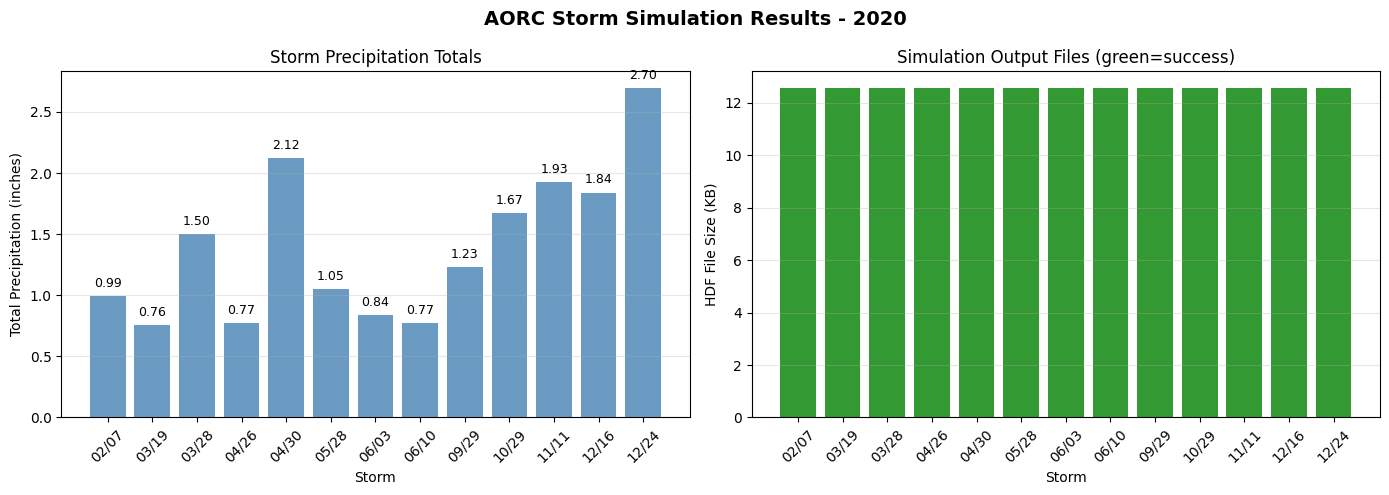


Storm Simulation Summary
Storm    Date         Precip (in)  Plan     HDF (KB)     Status
--------------------------------------------------------------------------------
1        02/07/2020   0.99         07       13           OK
2        03/19/2020   0.76         08       13           OK
3        03/28/2020   1.50         09       13           OK
4        04/26/2020   0.77         10       13           OK
5        04/30/2020   2.12         11       13           OK
6        05/28/2020   1.05         12       13           OK
7        06/03/2020   0.84         14       13           OK
8        06/10/2020   0.77         16       13           OK
9        09/29/2020   1.23         20       13           OK
10       10/29/2020   1.67         21       13           OK
11       11/11/2020   1.93         22       13           OK
12       12/16/2020   1.84         23       13           OK
13       12/24/2020   2.70         24       13           OK


In [13]:
# Create summary visualization
if storm_results:
    # Plot precipitation vs storm date
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Storm precipitation totals
    ax1 = axes[0]
    storm_dates = [r['start_time'].strftime('%m/%d') for r in storm_results]
    precip_totals = [r['total_depth_in'] for r in storm_results]
    
    bars = ax1.bar(range(len(storm_results)), precip_totals, color='steelblue', alpha=0.8)
    ax1.set_xlabel('Storm')
    ax1.set_ylabel('Total Precipitation (inches)')
    ax1.set_title('Storm Precipitation Totals')
    ax1.set_xticks(range(len(storm_results)))
    ax1.set_xticklabels(storm_dates, rotation=45)
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar, val in zip(bars, precip_totals):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
                f'{val:.2f}', ha='center', va='bottom', fontsize=9)
    
    # Simulation status/HDF sizes
    ax2 = axes[1]
    hdf_sizes = [r['hdf_size_kb'] for r in storm_results]
    colors = ['green' if r['exec_success'] and r['hdf_exists'] else 'red' for r in storm_results]
    
    ax2.bar(range(len(storm_results)), hdf_sizes, color=colors, alpha=0.8)
    ax2.set_xlabel('Storm')
    ax2.set_ylabel('HDF File Size (KB)')
    ax2.set_title('Simulation Output Files (green=success)')
    ax2.set_xticks(range(len(storm_results)))
    ax2.set_xticklabels(storm_dates, rotation=45)
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.suptitle(f'AORC Storm Simulation Results - {year}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print summary table
    print("\nStorm Simulation Summary")
    print("="*80)
    print(f"{'Storm':<8} {'Date':<12} {'Precip (in)':<12} {'Plan':<8} {'HDF (KB)':<12} {'Status'}")
    print("-"*80)
    for r in storm_results:
        if r['exec_success'] and r['hdf_exists']:
            status = "OK"
        elif r['exec_success']:
            status = "NO HDF"
        else:
            status = "FAILED"
        print(f"{r['storm_id']:<8} {r['start_time'].strftime('%m/%d/%Y'):<12} "
              f"{r['total_depth_in']:<12.2f} {r['plan_number']:<8} "
              f"{r['hdf_size_kb']:<12.0f} {status}")
else:
    print("No storm results available")

## Step 6b: Extract Time Series at Monitoring Point

Extract Water Surface Elevation (WSE), Depth, and Velocity time series at the monitoring point for each storm.

**Note**: Time series extraction requires successful simulation with HDF time series output enabled. If simulations did not complete with full results, this section will indicate that data is not available.

In [14]:
# Extract time series at monitoring point for each storm
import h5py
from scipy.spatial import cKDTree

print(f"Monitoring Point: {monitoring_point}")
print("="*80)

# Get cell centers from the first successful HDF file
cell_centers = None
cell_idx = None

for r in storm_results:
    if r['hdf_exists']:
        with h5py.File(r['hdf_path'], 'r') as f:
            # Get 2D area cell centers
            geom_path = 'Geometry/2D Flow Areas/BaldEagleCr'
            if f'{geom_path}/Cells Center Coordinate' in f:
                cell_centers = f[f'{geom_path}/Cells Center Coordinate'][:]
                print(f"Found {len(cell_centers)} cells in 2D mesh")
                
                # Build KD-tree and find nearest cell
                tree = cKDTree(cell_centers)
                dist, cell_idx = tree.query(monitoring_point)
                print(f"Nearest cell to monitoring point: Cell {cell_idx}")
                print(f"Distance to cell center: {dist:.2f} units")
                break

if cell_idx is None:
    print("Could not find cell centers in HDF files")
else:
    print(f"\nExtracting time series for Cell {cell_idx}...")

Monitoring Point: (2078811, 367670)
Could not find cell centers in HDF files


In [15]:
# Extract WSE, Depth, and Velocity time series for each storm at monitoring point
storm_timeseries = {}

if cell_idx is not None:
    for r in storm_results:
        if not r['hdf_exists']:
            continue
            
        storm_id = r['storm_id']
        hdf_path = r['hdf_path']
        
        try:
            with h5py.File(hdf_path, 'r') as f:
                # Get time series results
                results_path = 'Results/Unsteady/Output/Output Blocks/Base Output/Unsteady Time Series/2D Flow Areas/BaldEagleCr'
                
                ts_data = {'storm_id': storm_id, 'start_time': r['start_time']}
                
                # Water Surface Elevation
                if f'{results_path}/Water Surface' in f:
                    wse = f[f'{results_path}/Water Surface'][:, cell_idx]
                    ts_data['wse'] = wse
                
                # Depth (if available)
                if f'{results_path}/Depth' in f:
                    depth = f[f'{results_path}/Depth'][:, cell_idx]
                    ts_data['depth'] = depth
                
                # Cell Velocity (if available)
                if f'{results_path}/Cell Velocity' in f:
                    velocity = f[f'{results_path}/Cell Velocity'][:, cell_idx]
                    ts_data['velocity'] = velocity
                
                # Get timestamps
                time_path = 'Results/Unsteady/Output/Output Blocks/Base Output/Unsteady Time Series/Time Date Stamp'
                if time_path in f:
                    time_stamps = f[time_path][:]
                    # Decode timestamps
                    ts_data['times'] = pd.to_datetime([t.decode('utf-8').strip() for t in time_stamps])
                
                storm_timeseries[storm_id] = ts_data
                print(f"Storm {storm_id}: Extracted {len(ts_data.get('wse', []))} timesteps")
                
        except Exception as e:
            print(f"Storm {storm_id}: Error extracting data - {e}")
    
    print(f"\nExtracted time series for {len(storm_timeseries)} storms")

In [16]:
# Plot time series for each storm at monitoring point
if storm_timeseries:
    n_storms = len(storm_timeseries)
    n_cols = 3
    n_rows = (n_storms + n_cols - 1) // n_cols
    
    # Plot WSE
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
    axes = axes.flatten() if n_storms > 1 else [axes]
    
    for idx, (storm_id, ts_data) in enumerate(sorted(storm_timeseries.items())):
        ax = axes[idx]
        if 'wse' in ts_data and 'times' in ts_data:
            ax.plot(ts_data['times'], ts_data['wse'], 'b-', linewidth=1.5)
            ax.set_title(f"Storm {storm_id}: {ts_data['start_time'].strftime('%b %d, %Y')}", fontsize=10)
            ax.set_xlabel('Date')
            ax.set_ylabel('WSE (ft)')
            ax.tick_params(axis='x', rotation=45)
            ax.grid(True, alpha=0.3)
            
            # Add peak annotation
            peak_idx = np.argmax(ts_data['wse'])
            peak_wse = ts_data['wse'][peak_idx]
            ax.axhline(y=peak_wse, color='r', linestyle='--', alpha=0.5)
            ax.text(0.02, 0.98, f'Peak: {peak_wse:.2f} ft', transform=ax.transAxes, 
                   fontsize=9, verticalalignment='top')
    
    # Hide empty subplots
    for idx in range(n_storms, len(axes)):
        axes[idx].set_visible(False)
    
    plt.suptitle(f'Water Surface Elevation at Monitoring Point ({monitoring_point[0]}, {monitoring_point[1]})', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Plot Depth if available
    has_depth = any('depth' in ts for ts in storm_timeseries.values())
    if has_depth:
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
        axes = axes.flatten() if n_storms > 1 else [axes]
        
        for idx, (storm_id, ts_data) in enumerate(sorted(storm_timeseries.items())):
            ax = axes[idx]
            if 'depth' in ts_data and 'times' in ts_data:
                ax.plot(ts_data['times'], ts_data['depth'], 'g-', linewidth=1.5)
                ax.set_title(f"Storm {storm_id}: {ts_data['start_time'].strftime('%b %d, %Y')}", fontsize=10)
                ax.set_xlabel('Date')
                ax.set_ylabel('Depth (ft)')
                ax.tick_params(axis='x', rotation=45)
                ax.grid(True, alpha=0.3)
                
                # Add peak annotation
                peak_idx = np.argmax(ts_data['depth'])
                peak_depth = ts_data['depth'][peak_idx]
                ax.axhline(y=peak_depth, color='r', linestyle='--', alpha=0.5)
                ax.text(0.02, 0.98, f'Peak: {peak_depth:.2f} ft', transform=ax.transAxes, 
                       fontsize=9, verticalalignment='top')
        
        for idx in range(n_storms, len(axes)):
            axes[idx].set_visible(False)
        
        plt.suptitle(f'Water Depth at Monitoring Point ({monitoring_point[0]}, {monitoring_point[1]})', 
                     fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
    
    # Plot Velocity if available
    has_velocity = any('velocity' in ts for ts in storm_timeseries.values())
    if has_velocity:
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
        axes = axes.flatten() if n_storms > 1 else [axes]
        
        for idx, (storm_id, ts_data) in enumerate(sorted(storm_timeseries.items())):
            ax = axes[idx]
            if 'velocity' in ts_data and 'times' in ts_data:
                ax.plot(ts_data['times'], ts_data['velocity'], 'm-', linewidth=1.5)
                ax.set_title(f"Storm {storm_id}: {ts_data['start_time'].strftime('%b %d, %Y')}", fontsize=10)
                ax.set_xlabel('Date')
                ax.set_ylabel('Velocity (ft/s)')
                ax.tick_params(axis='x', rotation=45)
                ax.grid(True, alpha=0.3)
                
                # Add peak annotation
                peak_idx = np.argmax(ts_data['velocity'])
                peak_vel = ts_data['velocity'][peak_idx]
                ax.axhline(y=peak_vel, color='r', linestyle='--', alpha=0.5)
                ax.text(0.02, 0.98, f'Peak: {peak_vel:.2f} ft/s', transform=ax.transAxes, 
                       fontsize=9, verticalalignment='top')
        
        for idx in range(n_storms, len(axes)):
            axes[idx].set_visible(False)
        
        plt.suptitle(f'Cell Velocity at Monitoring Point ({monitoring_point[0]}, {monitoring_point[1]})', 
                     fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
else:
    print("No time series data available to plot")

No time series data available to plot


In [17]:
# Create summary comparison of peak values across all storms
if storm_timeseries:
    # Extract peak values for each storm
    peaks_data = []
    for storm_id, ts_data in sorted(storm_timeseries.items()):
        peak_info = {
            'storm_id': storm_id,
            'date': ts_data['start_time'].strftime('%m/%d'),
            'peak_wse': np.max(ts_data['wse']) if 'wse' in ts_data else None,
            'peak_depth': np.max(ts_data['depth']) if 'depth' in ts_data else None,
            'peak_velocity': np.max(ts_data['velocity']) if 'velocity' in ts_data else None,
        }
        peaks_data.append(peak_info)
    
    peaks_df = pd.DataFrame(peaks_data)
    
    # Create comparison bar chart
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    x = range(len(peaks_df))
    labels = peaks_df['date'].tolist()
    
    # Peak WSE
    ax1 = axes[0]
    if peaks_df['peak_wse'].notna().any():
        ax1.bar(x, peaks_df['peak_wse'], color='steelblue', alpha=0.8)
        ax1.set_xlabel('Storm Date')
        ax1.set_ylabel('Peak WSE (ft)')
        ax1.set_title('Peak Water Surface Elevation')
        ax1.set_xticks(x)
        ax1.set_xticklabels(labels, rotation=45)
        ax1.grid(True, alpha=0.3, axis='y')
    
    # Peak Depth
    ax2 = axes[1]
    if peaks_df['peak_depth'].notna().any():
        ax2.bar(x, peaks_df['peak_depth'], color='green', alpha=0.8)
        ax2.set_xlabel('Storm Date')
        ax2.set_ylabel('Peak Depth (ft)')
        ax2.set_title('Peak Water Depth')
        ax2.set_xticks(x)
        ax2.set_xticklabels(labels, rotation=45)
        ax2.grid(True, alpha=0.3, axis='y')
    
    # Peak Velocity
    ax3 = axes[2]
    if peaks_df['peak_velocity'].notna().any():
        ax3.bar(x, peaks_df['peak_velocity'], color='purple', alpha=0.8)
        ax3.set_xlabel('Storm Date')
        ax3.set_ylabel('Peak Velocity (ft/s)')
        ax3.set_title('Peak Cell Velocity')
        ax3.set_xticks(x)
        ax3.set_xticklabels(labels, rotation=45)
        ax3.grid(True, alpha=0.3, axis='y')
    
    plt.suptitle(f'Peak Values Comparison at Monitoring Point - {year}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print summary table
    print("\nMonitoring Point Peak Values Summary")
    print("="*70)
    print(f"Location: ({monitoring_point[0]}, {monitoring_point[1]})")
    print("-"*70)
    print(f"{'Storm':<8} {'Date':<12} {'Peak WSE (ft)':<15} {'Peak Depth (ft)':<16} {'Peak Vel (ft/s)'}")
    print("-"*70)
    for _, row in peaks_df.iterrows():
        wse_str = f"{row['peak_wse']:.2f}" if pd.notna(row['peak_wse']) else "N/A"
        depth_str = f"{row['peak_depth']:.2f}" if pd.notna(row['peak_depth']) else "N/A"
        vel_str = f"{row['peak_velocity']:.2f}" if pd.notna(row['peak_velocity']) else "N/A"
        print(f"{row['storm_id']:<8} {row['date']:<12} {wse_str:<15} {depth_str:<16} {vel_str}")

## Step 7: Review Precipitation Data Quality

Plot a comparison of storm characteristics from the catalog.

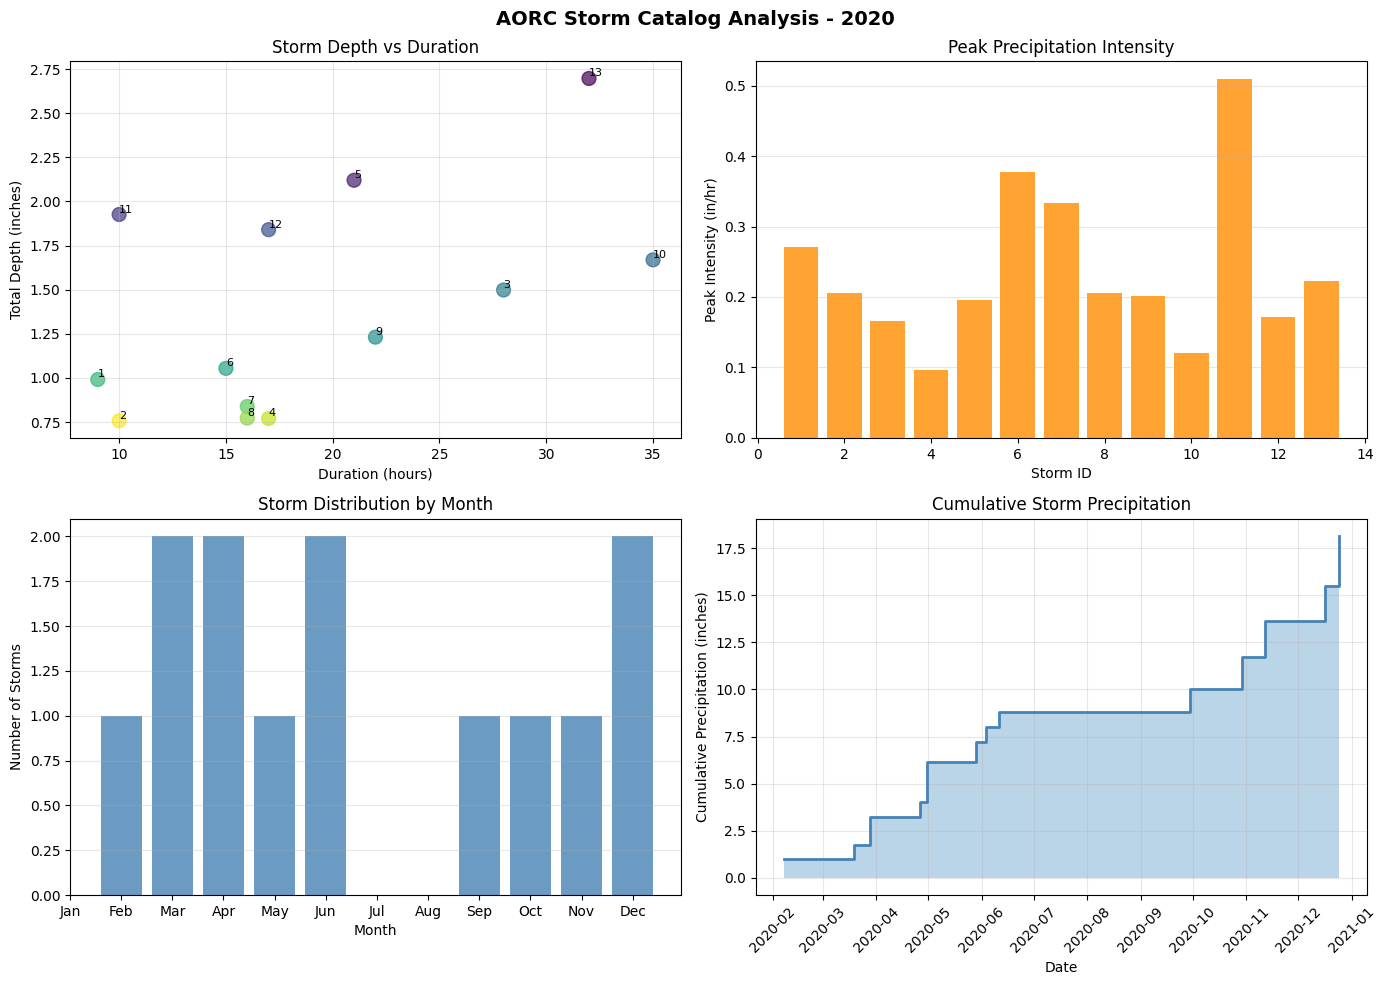


Storm Catalog Statistics
Total storms identified: 13
Total precipitation: 18.16 inches
Mean storm depth: 1.40 inches
Max storm depth: 2.70 inches
Mean peak intensity: 0.24 in/hr
Mean duration: 19.1 hours


In [18]:
# Storm characteristics comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Total depth vs duration
ax1 = axes[0, 0]
ax1.scatter(storm_catalog['duration_hours'], storm_catalog['total_depth_in'], 
            c=storm_catalog['rank'], cmap='viridis', s=100, alpha=0.7)
ax1.set_xlabel('Duration (hours)')
ax1.set_ylabel('Total Depth (inches)')
ax1.set_title('Storm Depth vs Duration')
ax1.grid(True, alpha=0.3)
for i, row in storm_catalog.iterrows():
    ax1.annotate(f"{row['storm_id']}", (row['duration_hours'], row['total_depth_in']),
                 fontsize=8, ha='left', va='bottom')

# 2. Peak intensity distribution
ax2 = axes[0, 1]
ax2.bar(storm_catalog['storm_id'], storm_catalog['peak_intensity_in_hr'], 
        color='darkorange', alpha=0.8)
ax2.set_xlabel('Storm ID')
ax2.set_ylabel('Peak Intensity (in/hr)')
ax2.set_title('Peak Precipitation Intensity')
ax2.grid(True, alpha=0.3, axis='y')

# 3. Temporal distribution of storms through the year
ax3 = axes[1, 0]
months = storm_catalog['start_time'].dt.month
monthly_counts = months.value_counts().sort_index()
ax3.bar(monthly_counts.index, monthly_counts.values, color='steelblue', alpha=0.8)
ax3.set_xlabel('Month')
ax3.set_ylabel('Number of Storms')
ax3.set_title('Storm Distribution by Month')
ax3.set_xticks(range(1, 13))
ax3.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax3.grid(True, alpha=0.3, axis='y')

# 4. Cumulative precipitation through the year
ax4 = axes[1, 1]
sorted_catalog = storm_catalog.sort_values('start_time')
cumsum = sorted_catalog['total_depth_in'].cumsum()
ax4.step(sorted_catalog['start_time'], cumsum, where='post', 
         color='steelblue', linewidth=2)
ax4.fill_between(sorted_catalog['start_time'], cumsum, step='post', alpha=0.3)
ax4.set_xlabel('Date')
ax4.set_ylabel('Cumulative Precipitation (inches)')
ax4.set_title('Cumulative Storm Precipitation')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(True, alpha=0.3)

plt.suptitle(f'AORC Storm Catalog Analysis - {year}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print statistics
print("\nStorm Catalog Statistics")
print("="*60)
print(f"Total storms identified: {len(storm_catalog)}")
print(f"Total precipitation: {storm_catalog['total_depth_in'].sum():.2f} inches")
print(f"Mean storm depth: {storm_catalog['total_depth_in'].mean():.2f} inches")
print(f"Max storm depth: {storm_catalog['total_depth_in'].max():.2f} inches")
print(f"Mean peak intensity: {storm_catalog['peak_intensity_in_hr'].mean():.2f} in/hr")
print(f"Mean duration: {storm_catalog['duration_hours'].mean():.1f} hours")

## Summary

This notebook demonstrated a complete AORC precipitation workflow:

1. **Storm Catalog Generation** - Identified precipitation events using USGS standard parameters (8-hour inter-event time)
2. **Precipitation Visualization** - Downloaded AORC data and plotted hyetographs for each storm
3. **Plan Creation** - Automatically created HEC-RAS plans for all storm events with `create_storm_plans()`
4. **Parallel Execution** - Ran all plans efficiently using `compute_parallel()`
5. **Results Summary** - Verified simulation completion and output files
6. **Time Series Extraction** - Extracted WSE, Depth, and Velocity at monitoring point (when available)
7. **Storm Analysis** - Compared storm characteristics across the catalog

### Key Functions Used

| Function | Description |
|----------|-------------|
| `PrecipAorc.get_storm_catalog()` | Generate catalog of precipitation events from AORC data |
| `PrecipAorc.download()` | Download AORC data to NetCDF in HEC SHG projection |
| `PrecipAorc.create_storm_plans()` | Batch create HEC-RAS plans with precipitation configured |
| `RasCmdr.compute_parallel()` | Execute plans in parallel |

### AORC Dataset

- **Source**: NOAA Analysis of Record for Calibration (AORC)
- **Bucket**: `s3://noaa-nws-aorc-v1-1-1km/`
- **Coverage**: CONUS (1979-present), hourly timesteps
- **Resolution**: ~800 meters (reprojected to 2km HEC SHG)

### Known Limitations

- **Precipitation Integration**: The current workflow downloads AORC data to NetCDF format, but HEC-RAS requires precipitation data in its internal HDF event conditions format. Manual configuration may be needed to properly link precipitation data to simulations.
- **DSS vs NetCDF**: Some HEC-RAS projects expect DSS precipitation files. Future enhancements may include NetCDF → DSS conversion.

### Notes

- Storm catalog uses USGS-standard 8-hour inter-event time for storm separation
- Precipitation files are saved in HEC SHG projection (EPSG:5070) as required by HEC-RAS
- Plans are created with `enable_timeseries=True` to enable HDF time series output
- For detailed cell-level results, ensure proper HDF output configuration in HEC-RAS